<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
import scipy.io
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
%pylab inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set()

In [3]:
!pip install -q pymer4

     |████████████████████████████████| 59 kB 2.0 MB/s 


In [4]:
from pymer4.models import Lmer

In [5]:
!pip install -q statsmodels

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [7]:
# Install R and Rpy2
!apt-get install r-base
!pip install -q rpy2

# Install LMER packages (THIS TAKES ABOUT 3~5 minutes)
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.2.0-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘numDeriv’, ‘estimability’, ‘mvtnorm’, ‘xtable’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/minqa_1.2.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 53548 bytes (52 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f4876e662d0> [RTYPES.NILSXP]

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R 
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [77]:
import warnings
warnings.filterwarnings("ignore")

## Uploading data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
working_path = Path('/content/drive/MyDrive/CoganLab')

IEEG dataset: ['D30', 'D33', 'D49', 'D54', 'D61', 'D65', 'D70'] this subjects are below 75% threshold. 213 No response trials (according to 'Resp' column). Column 'Out' contains infor on whether it is outlier or not. 

In [12]:
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_subset.csv'),
    index_col=None
)

EEG dataset without outliers but with 'no response' trials. Non of the subjects was rejected because all of them are above 75% accuracy.

In [13]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_no_outliers.csv'),
    index_col=None
)

In [14]:
ieeg = ieeg.loc[:, ieeg.columns != 'Unnamed: 0']
eeg = eeg.loc[:, eeg.columns != 'Unnamed: 0']

###EEG dataset

## Preprocessing of the EEG dataset

In [17]:
print(
    'Accuracy without "No response" trials',
    eeg[eeg['Response'] != 'No Response'].ResponseCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    eeg.ResponseCorrect.mean()
)

Accuracy without "No response" trials 0.8723482077542063
Accuracy with "No response" trials 0.8566810344827587


In [33]:
eeg_no_trials = eeg[eeg['Response'] != 'No Response']
print('Shape of the dataset with no response trials', eeg.shape)
print('Shape of the dataset without no response trials', eeg_no_trials.shape)

Shape of the dataset with no response trials (5568, 22)
Shape of the dataset without no response trials (5468, 22)


Mean 1.1349431817298263 Max 2.492920639537033 Min 0.4335620319443478


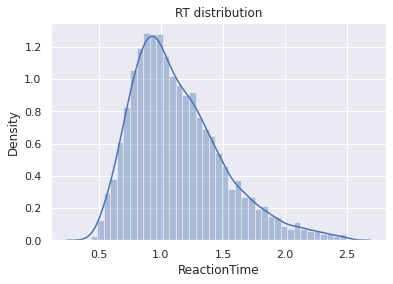

In [202]:
sns.distplot(eeg_no_trials.ReactionTime)
pl.title('RT distribution');
print(
    'Mean', eeg_no_trials.ReactionTime.mean(),
    'Max', eeg_no_trials.ReactionTime.max(),
    'Min', eeg_no_trials.ReactionTime.min()
)

In [203]:
values = []
for i in eeg_no_trials.Subject.unique():
  subset = eeg_no_trials[eeg_no_trials['Subject'] == i]
  q75 = np.percentile(subset['ReactionTime'], 75)
  q25 = np.percentile(subset['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset.ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

E2 2
E3 0
E4 0
E5 0
E6 3
E7 5
E8 3
E9 7
E10 6
E11 1
E12 1
E13 0
E15 0
E16 2
E17 0
E18 4
E20 1
E21 0
E22 0
E23 2
E24 2
E25 1
E26 0
E27 0
E28 0
E29 0
E30 0
E31 0
E33 7


In [204]:
len(values)

47

In [206]:
# recalculating stdRT
rts = eeg_no_trials['ReactionTime'].values
eeg_no_trials['stdRT'] = (eeg_no_trials['ReactionTime'] - rts.mean())/rts.std()

## Accuracy plots EEG dataset w/out No Response trials

BOTH MATCH AND MISMATCH: all conditions, W vs NW, H vs L

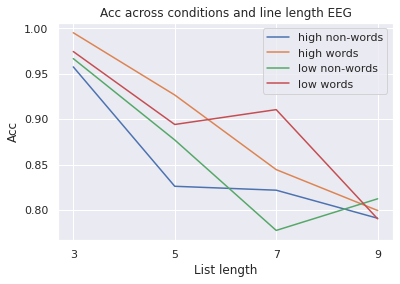

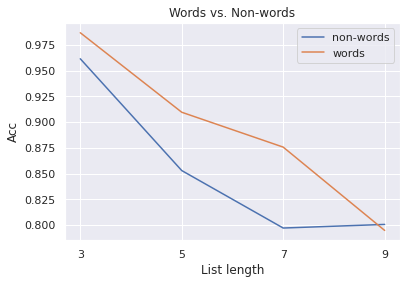

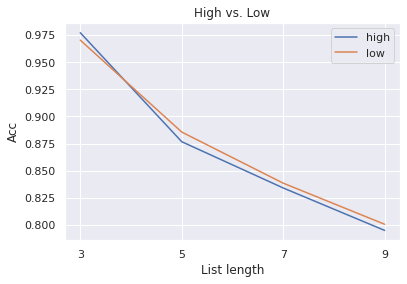

In [218]:
pl.figure()
subset = eeg_no_trials.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG');

pl.figure()
subset = eeg_no_trials.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words');

pl.figure()
subset = eeg_no_trials.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low');

ONLY MATCH: all cond's, W vs NW, H vs L

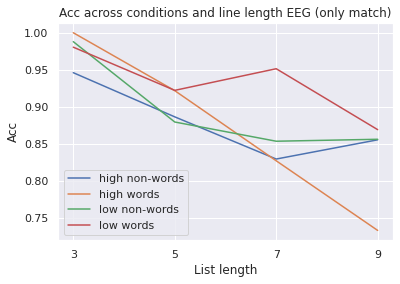

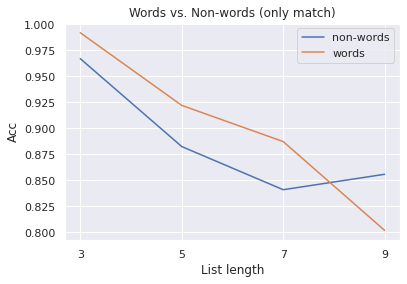

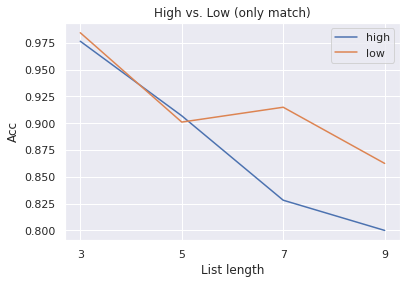

In [219]:
only_match = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only match)');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.ResponseCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.ResponseCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match)');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match)');

ONLY MISMATCH: all cond's, W vs NW, H vs L

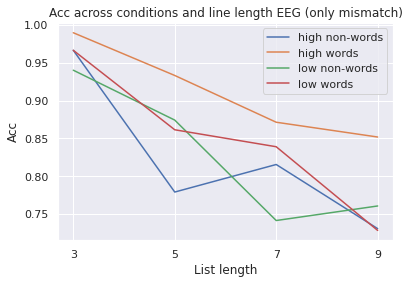

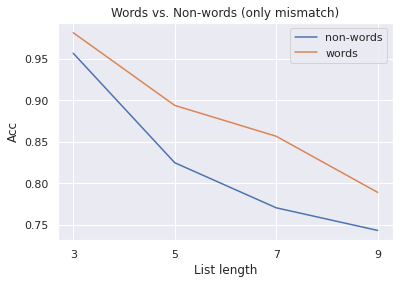

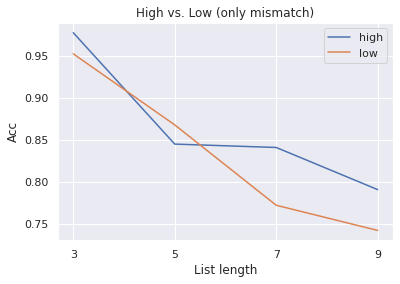

In [220]:
only_mismatch = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch)');

Plotting match vs mismatch on the same plot

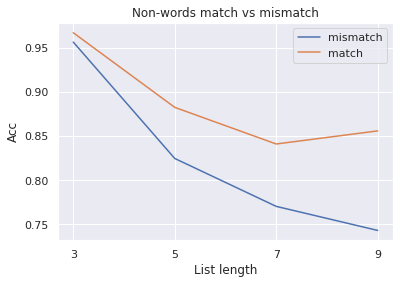

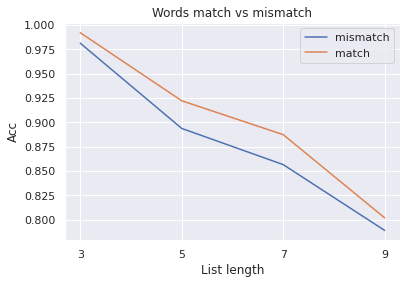

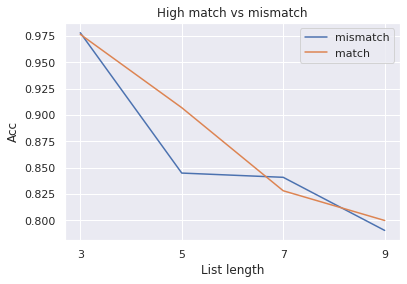

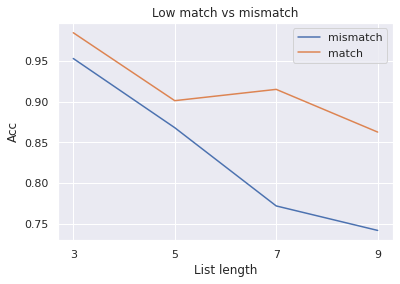

In [221]:
pl.figure()
nonwords = eeg_no_trials[eeg_no_trials['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch');

pl.figure()
words = eeg_no_trials[eeg_no_trials['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch');

pl.figure()
high = eeg_no_trials[eeg_no_trials['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch');

pl.figure()
low = eeg_no_trials[eeg_no_trials['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch');

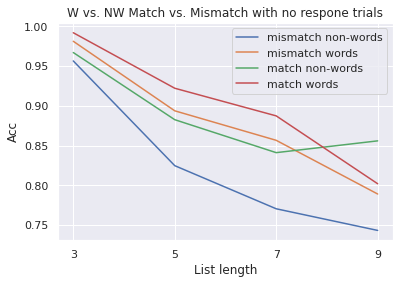

In [222]:
pl.figure()
subset = eeg_no_trials.groupby(['ProbeType', 'Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  for j in subset.Lex.unique():
    x = subset[(subset['ProbeType'] == i) & (subset['Lex'] == j)]
    if i == 1:
      name1 = 'mismatch'
      if j == 0:
        name2 = 'non-words'
      elif j == 1:
        name2 = 'words'
    elif i == 2:
      name1 = 'match'
      if j == 0:
        name2 = 'non-words'
      elif j == 1:
        name2 = 'words'
    pl.plot(x.Length, x.ResponseCorrect, label = (name1 + ' ' + name2))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('W vs. NW Match vs. Mismatch with no respone trials');

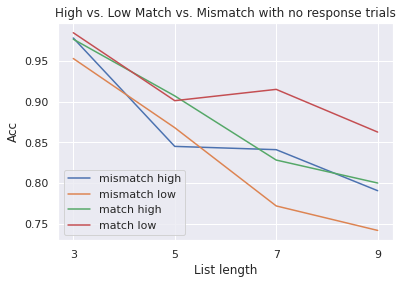

In [223]:
pl.figure()
subset = eeg_no_trials.groupby(['ProbeType', 'Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  for j in subset.Phono.unique():
    x = subset[(subset['ProbeType'] == i) & (subset['Phono'] == j)]
    if i == 1:
      name1 = 'mismatch'
      if j == 0:
        name2 = 'high'
      elif j == 1:
        name2 = 'low'
    elif i == 2:
      name1 = 'match'
      if j == 0:
        name2 = 'high'
      elif j == 1:
        name2 = 'low'
    pl.plot(x.Length, x.ResponseCorrect, label = (name1 + ' ' + name2))
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low Match vs. Mismatch with no response trials');

## Accuracy bar plots

**Bar plots. Investigating the effect of phono within the lexical class, probe types and list lengths**

In [44]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

P-value 0.6727489175153997
H 0.8742004264392325 L 0.8703843255463452


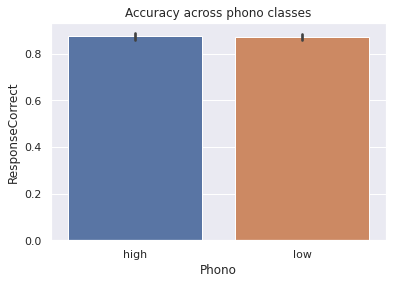

In [85]:
# W vs NW
pl.figure()
fig = sns.barplot('Phono', 'ResponseCorrect', data=eeg_no_trials)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy across phono classes');

x, y = eeg_no_trials[eeg_no_trials['Phono'] == 1]['ResponseCorrect'].values, eeg_no_trials[eeg_no_trials['Phono'] == 0]['ResponseCorrect'].values
print('P-value', ttest(x, y)[1])
print('H', y.mean(), 'L', x.mean())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


P-value for non-words 0.8638311002330827
H 0.8516363636363636 L 0.8539659006671608


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


P-value for words 0.48004262404523024
H 0.8957609451007644 L 0.8873563218390804


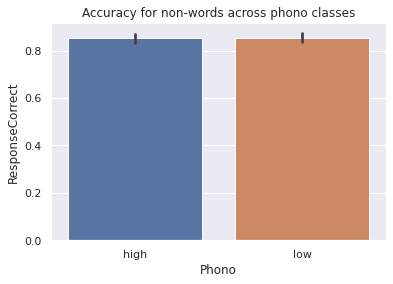

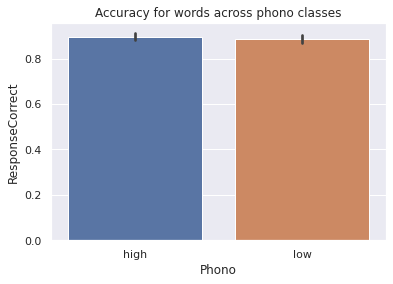

In [56]:
# W H vs L, NW H vs L
for i in eeg_no_trials.Lex.unique():
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.figure()
  subset = eeg_no_trials[eeg_no_trials['Lex'] == i]
  fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
  fig.set_xticklabels(['high', 'low'])
  pl.title('Accuracy for ' + name + ' across phono classes');

  x, y = subset[subset['Phono'] == 1]['ResponseCorrect'].values, subset[subset['Phono'] == 0]['ResponseCorrect'].values
  print('P-value for', name, ttest(x, y)[1])
  print('H', y.mean(), 'L', x.mean())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


P-value for non-words match 0.38886227649947747
H 0.8812199036918138 L 0.8964451313755796
P-value for non-words mismatch 0.5410702811269823
H 0.8271276595744681 L 0.8148148148148148


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


P-value for words match 0.0005943778897988538
H 0.8803088803088803 L 0.9320113314447592
P-value for words mismatch 2.491550456799733e-05
H 0.9138972809667674 L 0.8347245409015025


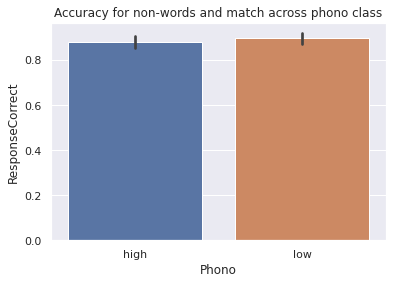

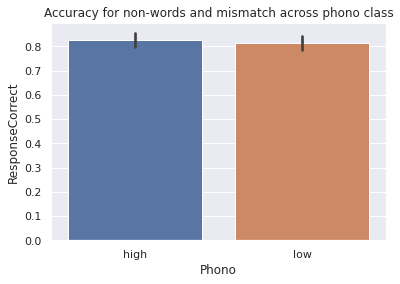

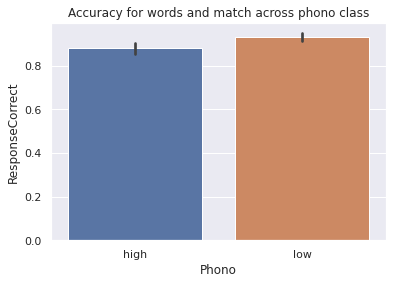

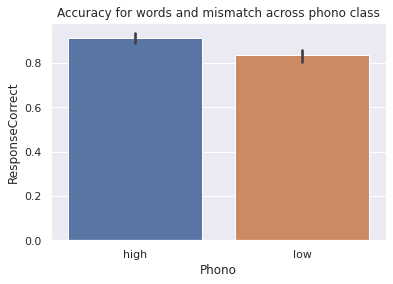

In [59]:
# 1/ W MATCH H vs L, 2/ W MISMATCH H vs L 
# 3/ NW MATCH H vs L, 4/ NW MISMATCH H vs L
for lex_class in eeg_no_trials.Lex.unique():
  if lex_class == 0:
    name1 = 'non-words'
  elif lex_class == 1:
    name1 = 'words'
  subset = eeg_no_trials[eeg_no_trials['Lex'] == lex_class]
  for probe_class in subset.ProbeType.unique():
    if probe_class == 1:
      name2 = 'mismatch'
    elif probe_class == 2:
      name2 = 'match'
    ss = subset[subset['ProbeType'] == probe_class]

    pl.figure()
    fig = sns.barplot('Phono', 'ResponseCorrect', data=ss)
    fig.set_xticklabels(['high', 'low'])
    pl.title(
        'Accuracy for ' + name1 + ' and ' + name2 + ' across phono class'
    );

    x, y = ss[ss['Phono'] == 1]['ResponseCorrect'].values, ss[ss['Phono'] == 0]['ResponseCorrect'].values
    print('P-value for', name1, name2, ttest(x, y)[1])
    print('H', y.mean(), 'L', x.mean())

P-value for 5 0.6122424229818959
H 0.8767334360554699 L 0.8856345885634589
P-value for 9 0.7944523842830024
H 0.7949438202247191 L 0.8006088280060882
P-value for 7 0.8246059380268297
H 0.8340874811463047 L 0.8385269121813032
P-value for 3 0.44045114068443014
H 0.9772151898734177 L 0.9703832752613241


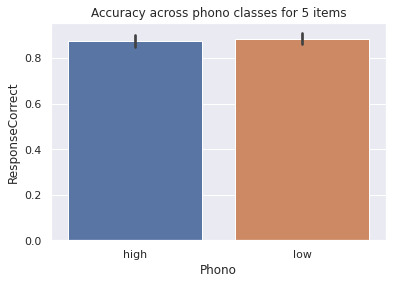

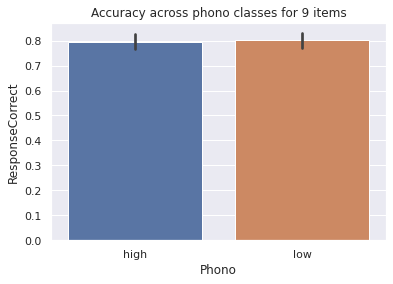

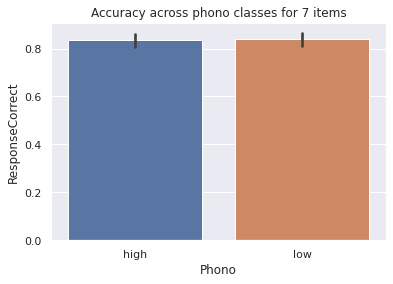

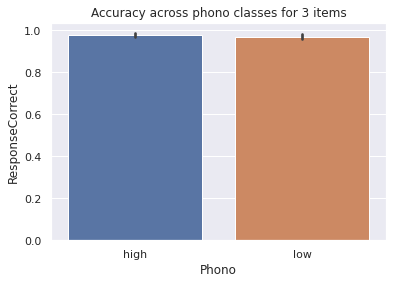

In [86]:
# check for different length
# H vs L
for i in eeg_no_trials.Length.unique():
  subset = eeg_no_trials[eeg_no_trials['Length'] == i] 
  pl.figure()
  fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
  fig.set_xticklabels(['high', 'low'])
  pl.title('Accuracy across phono classes for ' + str(i) + ' items');

  x, y = subset[subset['Phono'] == 1]['ResponseCorrect'].values, subset[subset['Phono'] == 0]['ResponseCorrect'].values
  print('P-value for', i, ttest(x, y)[1])
  print('H', y.mean(), 'L', x.mean())

In [ ]:
# check for different length
for i in eeg_no_trials.Length.unique():
  print(i)
  subset = eeg_no_trials[eeg_no_trials['Length'] == i]
  for j in subset.Lex.unique():
    if j == 0:
      print('Non-words')
    elif j == 1:
      print('Words')
    ss = subset[subset['Lex'] == j]
    x, y = ss[ss['Phono'] == 1]['ResponseCorrect'].values, ss[ss['Phono'] == 0]['ResponseCorrect'].values
    print('P-value for', i, j, ttest(x, y)[1])
    print('H', y.mean(), 'L', x.mean())

In [83]:
# check for different length

# 1/ W MATCH H vs L, 2/ W MISMATCH H vs L 
# 3/ NW MATCH H vs L, 4/ NW MISMATCH H vs L
for i in eeg_no_trials.Length.unique():
  subset = eeg_no_trials[eeg_no_trials['Length'] == i]
  for lex_class in subset.Lex.unique():
    if lex_class == 0:
      name1 = 'non-words'
    elif lex_class == 1:
      name1 = 'words'
    ss = subset[subset['Lex'] == lex_class]
    for probe_class in subset.ProbeType.unique():
      if probe_class == 1:
        name2 = 'mismatch'
      elif probe_class == 2:
        name2 = 'match'
      s = ss[ss['ProbeType'] == probe_class]

      x, y = s[s['Phono'] == 1]['ResponseCorrect'].values, s[s['Phono'] == 0]['ResponseCorrect'].values
      print('P-value for', i, 'items', name1, name2, ttest(x, y)[1])
      print('H', y.mean(), 'L', x.mean())
      print('')

P-value for 5 items non-words match 0.8460046146154283
H 0.8865248226950354 L 0.8795811518324608

P-value for 5 items non-words mismatch 0.018475922729785925
H 0.7790055248618785 L 0.874251497005988

P-value for 5 items words match 0.988217845604443
H 0.921875 L 0.9222797927461139

P-value for 5 items words mismatch 0.03784505843530323
H 0.9333333333333333 L 0.8614457831325302

P-value for 9 items words match 0.00298871877267468
H 0.7333333333333333 L 0.869281045751634

P-value for 9 items words mismatch 0.0028247599669562152
H 0.8518518518518519 L 0.7282051282051282

P-value for 9 items non-words match 0.9845793679644135
H 0.8555555555555555 L 0.8562874251497006

P-value for 9 items non-words mismatch 0.5336479966627193
H 0.7305699481865285 L 0.7605633802816901

P-value for 7 items non-words mismatch 0.06818266938957976
H 0.8154761904761905 L 0.7413127413127413

P-value for 7 items non-words match 0.598635103454678
H 0.8296296296296296 L 0.8536585365853658

P-value for 7 items words m

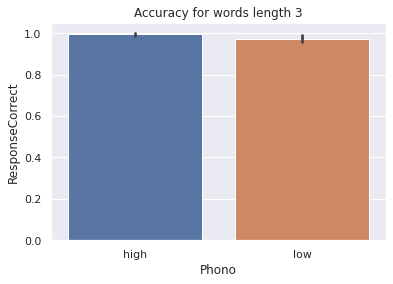

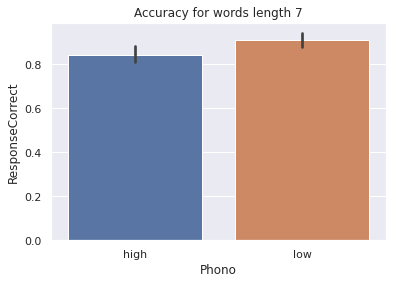

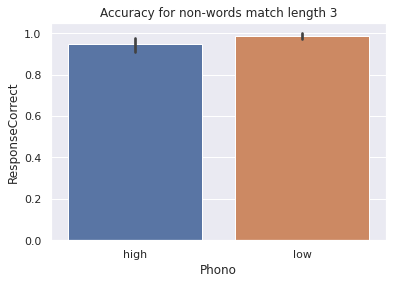

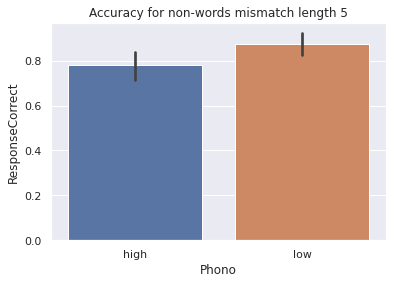

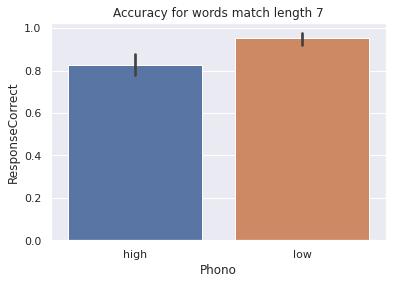

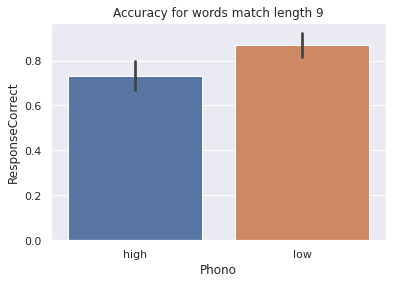

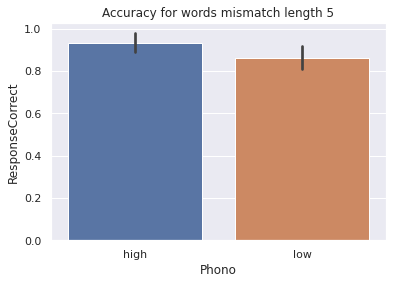

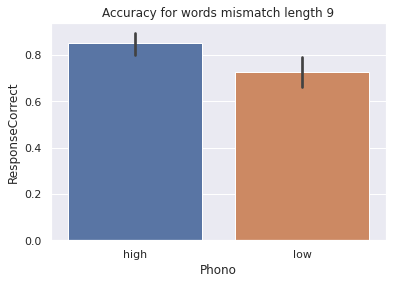

In [89]:
# plotting sgnificant differences by lists
# first contrast Phono within word classes
pl.figure()
subset = eeg_no_trials[(eeg_no_trials['Lex'] == 1) & (eeg_no_trials['Length'] == 3)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words length 3');

pl.figure()
subset = eeg_no_trials[(eeg_no_trials['Lex'] == 1) & (eeg_no_trials['Length'] == 7)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words length 7');

pl.figure()
subset = eeg_no_trials[(eeg_no_trials['Lex'] == 0) & (eeg_no_trials['Length'] == 3) & (eeg_no_trials['ProbeType'] == 2)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for non-words match length 3');

pl.figure()
subset = eeg_no_trials[(eeg_no_trials['Lex'] == 0) & (eeg_no_trials['Length'] == 5) & (eeg_no_trials['ProbeType'] == 1)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for non-words mismatch length 5');

pl.figure()
subset = eeg_no_trials[(eeg_no_trials['Lex'] == 1) & (eeg_no_trials['Length'] == 7) & (eeg_no_trials['ProbeType'] == 2)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words match length 7');

pl.figure()
subset = eeg_no_trials[(eeg_no_trials['Lex'] == 1) & (eeg_no_trials['Length'] == 9) & (eeg_no_trials['ProbeType'] == 2)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words match length 9');

pl.figure()
subset = eeg_no_trials[(eeg_no_trials['Lex'] == 1) & (eeg_no_trials['Length'] == 5) & (eeg_no_trials['ProbeType'] == 1)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words mismatch length 5');

pl.figure()
subset = eeg_no_trials[(eeg_no_trials['Lex'] == 1) & (eeg_no_trials['Length'] == 9) & (eeg_no_trials['ProbeType'] == 1)]
fig = sns.barplot('Phono', 'ResponseCorrect', data=subset)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy for words mismatch length 9');

## RT plots 

Both MATCH AND MISMATCH TOGETHER

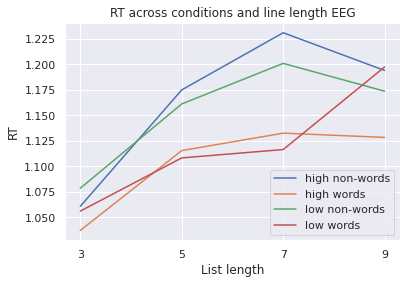

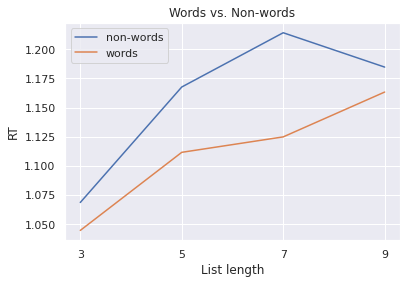

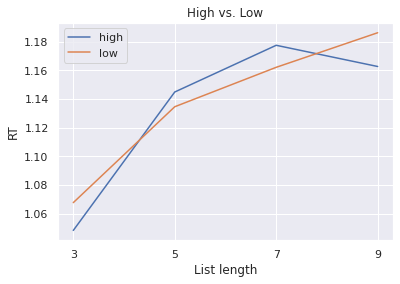

In [225]:
pl.figure()
subset = eeg_no_trials.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG');

pl.figure()
subset = eeg_no_trials.groupby(['Lex', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words');

pl.figure()
subset = eeg_no_trials.groupby(['Phono', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low');

P-value 1.309720982627964e-06
P-value 0.3002103533792985


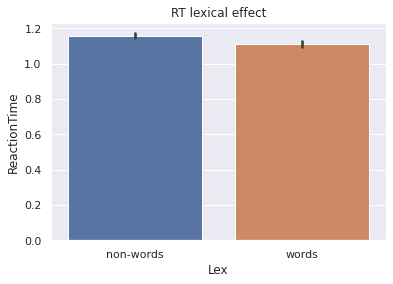

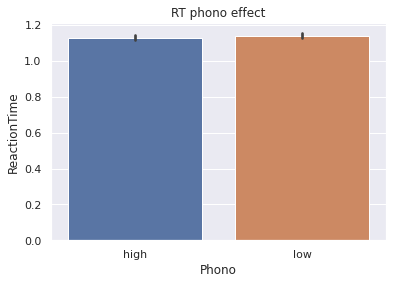

In [230]:
# significance with length combined
x, y = eeg_no_trials[eeg_no_trials['Lex'] == 1]['ReactionTime'].values, eeg_no_trials[eeg_no_trials['Lex'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(eeg_no_trials['Lex'], eeg_no_trials['ReactionTime'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect');

x, y = eeg_no_trials[eeg_no_trials['Phono'] == 1]['ReactionTime'].values, eeg_no_trials[eeg_no_trials['Phono'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(eeg_no_trials['Phono'], eeg_no_trials['ReactionTime'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect');

In [231]:
# significance with different lengths
for i in eeg_no_trials.Length.unique():
  subset = eeg_no_trials[eeg_no_trials['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['ReactionTime'].values, subset[subset['Lex'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['ReactionTime'].values, subset[subset['Phono'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

P-value for 5 Lex 0.004402819165934881
P-value for 5 Phono 0.6034518842805721
P-value for 9 Lex 0.27900389918254753
P-value for 9 Phono 0.23524279670760545
P-value for 7 Lex 1.2296895690775139e-05
P-value for 7 Phono 0.4538314468381355
P-value for 3 Lex 0.1990574403213983
P-value for 3 Phono 0.30126804748000824


MATCH

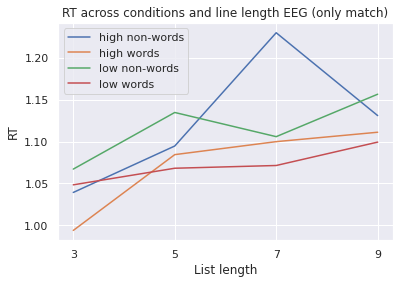

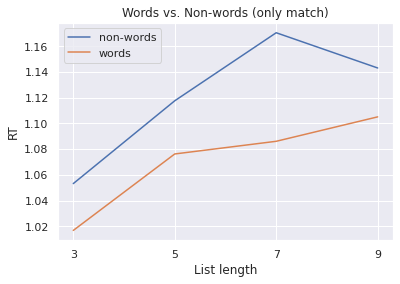

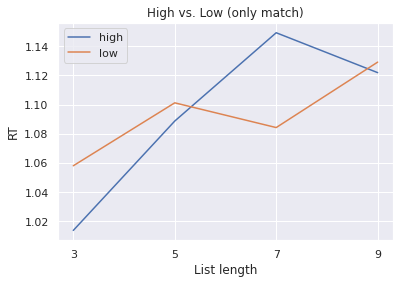

In [226]:
only_match = eeg_no_trials[eeg_no_trials['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG (only match)');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.ReactionTime, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.ReactionTime, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words (only match)');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low (only match)');

P-value 0.00015197441867710848
P-value 0.8720029620256665


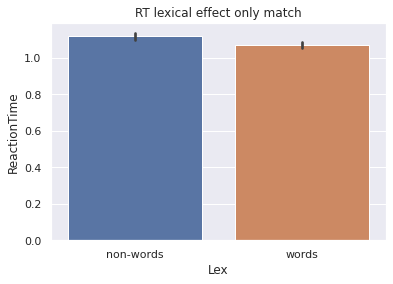

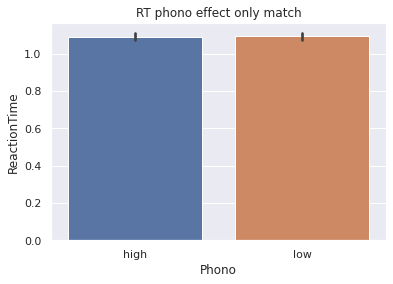

In [232]:
# significance with length combined
x, y = only_match[only_match['Lex'] == 1]['ReactionTime'].values, only_match[only_match['Lex'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_match['Lex'], only_match['ReactionTime'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect only match');

x, y = only_match[only_match['Phono'] == 1]['ReactionTime'].values, only_match[only_match['Phono'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_match['Phono'], only_match['ReactionTime'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect only match');

In [233]:
# significance with different lengths
print('Only match')
for i in only_match.Length.unique():
  subset = only_match[only_match['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['ReactionTime'].values, subset[subset['Lex'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['ReactionTime'].values, subset[subset['Phono'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

Only match
P-value for 5 Lex 0.09840065941468577
P-value for 5 Phono 0.6182171504596798
P-value for 9 Lex 0.1429818414366755
P-value for 9 Phono 0.7808570910120656
P-value for 7 Lex 0.002579023196615695
P-value for 7 Phono 0.013577813637014612
P-value for 3 Lex 0.12871467484789983
P-value for 3 Phono 0.065869266611883


MISMATCH

In [ ]:
only_mismatch = eeg_no_trials[eeg_no_trials['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low (only mismatch)');

In [ ]:
# significance with length combined
x, y = only_mismatch[only_mismatch['Lex'] == 1]['ReactionTime'].values, only_mismatch[only_mismatch['Lex'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_mismatch['Lex'], only_mismatch['ReactionTime'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect only mismatch');

x, y = only_mismatch[only_mismatch['Phono'] == 1]['ReactionTime'].values, only_mismatch[only_mismatch['Phono'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_mismatch['Phono'], only_mismatch['ReactionTime'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect only mismatch');

In [ ]:
# significance with different lengths
print('Only mismatch')
for i in only_mismatch.Length.unique():
  subset = only_mismatch[only_mismatch['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['ReactionTime'].values, subset[subset['Lex'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['ReactionTime'].values, subset[subset['Phono'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

Plotting MATCH AND MISMATCH on the same plot

In [ ]:
pl.figure()
nonwords = eeg_no_trials[eeg_no_trials['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Non-words match vs mismatch');

pl.figure()
words = eeg_no_trials[eeg_no_trials['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words match vs mismatch');

pl.figure()
high = eeg_no_trials[eeg_no_trials['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High match vs mismatch');

pl.figure()
low = eeg_no_trials[eeg_no_trials['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Low match vs mismatch');

## Ttests

In [16]:
eeg_data = eeg[[
                'Trial', 'Subject', 'Block',
                'ProbeType', 'stdRT', 'ResponseCorrect',
                'Position', 'Response', 'Length', 'Lex', 'Phono'
]]

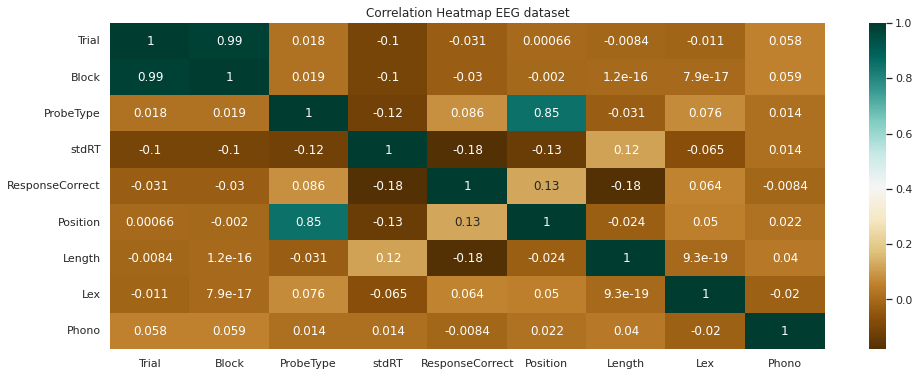

In [17]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(eeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap EEG dataset');

In [43]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

In [187]:
eeg_subset = eeg[eeg['Response'] != 'No Response']
high = eeg[eeg_subset['Phono'] == 0]
low = eeg[eeg_subset['Phono'] == 1]

In [207]:
x, y = low[low['ProbeType'] == 1]['ResponseCorrect'].values, low[low['ProbeType'] == 2]['ResponseCorrect'].values
ttest(x, y)

Ttest_indResult(statistic=-7.112692090412871, pvalue=1.4837511779543144e-12)

In [ ]:
x, y = low[low['ProbeType'] == 1]['ResponseCorrect'].values, low[low['ProbeType'] == 2]['ResponseCorrect'].values
ttest(x, y)

In [208]:
for i in low.Length.unique():
  subset = low[low['Length'] == i]
  a = subset[subset['ProbeType'] == 2]['ResponseCorrect'].values
  b = subset[subset['ProbeType'] == 1]['ResponseCorrect'].values
  print(ttest(a,b), i)

Ttest_indResult(statistic=1.7598149984465679, pvalue=0.07888912351127911) 5
Ttest_indResult(statistic=3.676012845863057, pvalue=0.00025638416637370677) 9
Ttest_indResult(statistic=2.273641055643646, pvalue=0.023486894652843857) 3
Ttest_indResult(statistic=5.447939173024526, pvalue=7.104203842824602e-08) 7


In [191]:
for i in mismatch.Length.unique():
  subset = mismatch[mismatch['Length'] == i]
  a = subset[subset['Phono'] == 0]['ResponseCorrect'].values
  b = subset[subset['Phono'] == 1]['ResponseCorrect'].values
  print(ttest(a,b), i)


Ttest_indResult(statistic=2.295681252274476, pvalue=0.021997510580035042) 7
Ttest_indResult(statistic=1.6573690105265337, pvalue=0.09822134201775866) 3
Ttest_indResult(statistic=-0.8310717387483997, pvalue=0.40624402578821606) 5
Ttest_indResult(statistic=1.5376887978558298, pvalue=0.12458317166074365) 9


## Models

Full model with all IVs: lex, phono, length, probe, position.

In [56]:
null_model = Lmer(
    'ResponseCorrect ~ (1|Subject)',
    data = eeg_data
    )
null_model.fit()

Formula: ResponseCorrect~(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -2044.152 	 AIC: 4088.304

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.043
Residual               0.121  0.348

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE    DF  T-stat  P-val  Sig
(Intercept)     0.857   0.839    0.875  0.009  28.0  92.361    0.0  ***

In [87]:
model1 = Lmer(
    'ResponseCorrect ~ Phono + (1|Subject)', 
    data=eeg_data
    )
model1.fit()

Formula: ResponseCorrect~Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -2047.704 	 AIC: 4095.408

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.043
Residual               0.121  0.348

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.860   0.839    0.880  0.010    42.960  83.257  0.000  ***
Phono          -0.006  -0.024    0.012  0.009  5538.336  -0.638  0.523

In [35]:
model_full = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -1941.963 	 AIC: 3883.927

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.044
Residual               0.116  0.341

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.919   0.877    0.961  0.022   714.845  42.719  0.000  ***
Lex             0.040   0.022    0.058  0.009  5535.021   4.412  0.000  ***
Phono          -0.001  -0.019    0.017  0.009  5535.321  -0.114  0.909     
Length         -0.027  -0.031   -0.023  0.002  5535.002 -13.345  0.000  ***
ProbeType       0.054   0.036    0.072  0.009  5538.844   5.932  0.000  ***

In [ ]:
model_full1 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full1.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1557.591 	 AIC: 3115.182

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.103  0.321

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.043   0.952    1.135  0.047  4687.303  22.328  0.000   
Lex                  0.121   0.047    0.195  0.038  5295.857   3.200  0.001   
Phono               -0.120  -0.194   -0.046  0.038  5296.443  -3.167  0.002   
Length              -0.039  -0.052   -0.026  0.007  5301.324  -5.767  0.000   
ProbeType           -0.014  -0.069    0.040  0.028  5301.021  -0.511  0.609   
Lex:Phono           -0.009  -0.043    0.026  0.018  5297.637  -0.487  0.626   
Lex:Length          -0.004  -0.012    0.004  0.004  5295.605  -0.990  0.322   
Lex:ProbeType       -0.041  -0.075   -0.006  0.018  5296.787  -2.322  0.020   
Phono:Length         0.002  -0.005    0.010  0.004  5298.372   0.623  0.534   
Phono:ProbeType      0.072   0.037    0.106  0.018  5295.726   4.072  0.000   
Length:ProbeType     0.008  -0.000    0.015  0.004  5304.838   1.915  0.055   

                  Sig  
(Intercept)       ***  
Lex                **  
Phono              **  
Length            ***  
ProbeType              
Lex:Phono              
Lex:Length             
Lex:ProbeType       *  
Phono:Length           
Phono:ProbeType   ***  
Length:ProbeType    .

In [ ]:
model_full2 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Phono*ProbeType + Lex*Length*ProbeType + Phono*Length*ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full2.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Phono*ProbeType+Lex*Length*ProbeType+Phono*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1560.294 	 AIC: 3120.589

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.102  0.320

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                0.987   0.854    1.121  0.068  5219.506  14.527   
Lex                        0.070  -0.097    0.238  0.085  5294.361   0.825   
Phono                      0.180   0.007    0.353  0.088  5293.853   2.039   
Length                    -0.036  -0.057   -0.015  0.010  5294.441  -3.437   
ProbeType                  0.017  -0.068    0.102  0.043  5293.520   0.383   
Lex:Phono                 -0.244  -0.390   -0.098  0.075  5296.593  -3.275   
Lex:Length                 0.018  -0.007    0.043  0.013  5293.447   1.433   
Lex:ProbeType              0.009  -0.095    0.112  0.053  5294.217   0.162   
Phono:Length              -0.033  -0.059   -0.008  0.013  5293.291  -2.545   
Phono:ProbeType           -0.107  -0.212   -0.002  0.054  5292.321  -1.999   
Length:ProbeType           0.007  -0.006    0.020  0.007  5295.634   1.045   
Lex:Phono:Length           0.010  -0.005    0.026  0.008  5292.998   1.308   
Lex:Phono:ProbeType        0.115   0.046    0.184  0.035  5295.915   3.254   
Lex:Length:ProbeType      -0.018  -0.033   -0.002  0.008  5293.828  -2.239   
Phono:Length:ProbeType     0.020   0.005    0.036  0.008  5291.928   2.584   

                        P-val  Sig  
(Intercept)             0.000  ***  
Lex                     0.409       
Phono                   0.041    *  
Length                  0.001  ***  
ProbeType               0.701       
Lex:Phono               0.001   **  
Lex:Length              0.152       
Lex:ProbeType           0.872       
Phono:Length            0.011    *  
Phono:ProbeType         0.046    *  
Length:ProbeType        0.296       
Lex:Phono:Length        0.191       
Lex:Phono:ProbeType     0.001   **  
Lex:Length:ProbeType    0.025    *  
Phono:Length:ProbeType  0.010   **

In [ ]:
model_full3 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Length*ProbeType + Lex*Phono*ProbeType + Phono*Length*ProbeType + Phono*Lex*Length*ProbeType + (1|Subject)', 
    data=eeg_data
    )
model_full3.fit()

Formula: ResponseCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Length*ProbeType+Lex*Phono*ProbeType+Phono*Length*ProbeType+Phono*Lex*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1558.639 	 AIC: 3117.278

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.102  0.320

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  \
(Intercept)                    1.087   0.940    1.234  0.075  5263.407   
Lex                           -0.128  -0.336    0.080  0.106  5295.322   
Phono                         -0.045  -0.268    0.178  0.114  5295.041   
Length                        -0.053  -0.076   -0.030  0.012  5292.822   
ProbeType                     -0.051  -0.146    0.044  0.048  5292.527   
Lex:Phono                      0.204  -0.112    0.520  0.161  5296.754   
Lex:Length                     0.052   0.019    0.084  0.017  5293.682   
Lex:ProbeType                  0.142   0.009    0.275  0.068  5294.918   
Phono:Length                   0.004  -0.031    0.039  0.018  5293.950   
Phono:ProbeType                0.042  -0.098    0.182  0.072  5293.421   
Length:ProbeType               0.018   0.003    0.033  0.008  5293.162   
Lex:Phono:Length              -0.064  -0.113   -0.015  0.025  5294.365   
Lex:Length:ProbeType          -0.040  -0.061   -0.019  0.011  5293.396   
Lex:Phono:ProbeType           -0.182  -0.380    0.017  0.101  5295.690   
Phono:Length:ProbeType        -0.004  -0.026    0.017  0.011  5292.391   
Lex:Phono:Length:ProbeType     0.049   0.018    0.080  0.016  5293.316   

                            T-stat  P-val  Sig  
(Intercept)                 14.496  0.000  ***  
Lex                         -1.204  0.229       
Phono                       -0.394  0.694       
Length                      -4.485  0.000  ***  
ProbeType                   -1.055  0.291       
Lex:Phono                    1.263  0.207       
Lex:Length                   3.105  0.002   **  
Lex:ProbeType                2.098  0.036    *  
Phono:Length                 0.221  0.825       
Phono:ProbeType              0.585  0.559       
Length:ProbeType             2.417  0.016    *  
Lex:Phono:Length            -2.556  0.011    *  
Lex:Length:ProbeType        -3.766  0.000  ***  
Lex:Phono:ProbeType         -1.797  0.072    .  
Phono:Length:ProbeType      -0.394  0.694       
Lex:Phono:Length:ProbeType   3.128  0.002   **

Models after comparison

In [286]:
%%R
m <- lmer('ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + (1|Subject)', data=eeg_data)
m1 <- lmer('ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Lex*ProbeType*Length + (1|Subject)', data=eeg_data)
anova(m, m1)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    7 3850.213 3896.586 -1918.106 3836.213       NA NA         NA
2   10 3848.742 3914.990 -1914.371 3828.742 7.471199  3 0.05830311


In [109]:
final1 = Lmer(
    'ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + (1|Subject)',
    data = eeg_data
)
final1.fit()

Formula: ResponseCorrect~Lex+ProbeType+Length+Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -1937.778 	 AIC: 3875.555

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.044
Residual               0.116  0.340

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)       0.884   0.835    0.933  0.025  1178.957  35.481  0.000  ***
Lex               0.113   0.056    0.170  0.029  5535.822   3.906  0.000  ***
ProbeType         0.079   0.053    0.104  0.013  5538.283   6.069  0.000  ***
Length           -0.027  -0.031   -0.023  0.002  5535.000 -13.419  0.000  ***
Lex:ProbeType    -0.048  -0.084   -0.013  0.018  5535.955  -2.646  0.008   **

In [114]:
final2 = Lmer(
    'ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Lex*ProbeType*Length + (1|Subject)',
    data = eeg_data
)
final2.fit()

Formula: ResponseCorrect~Lex+ProbeType+Length+Lex*ProbeType+Lex*ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5568	 Groups: {'Subject': 29.0}

Log-likelihood: -1947.097 	 AIC: 3894.194

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.044
Residual               0.116  0.340

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)              0.995   0.880    1.109  0.059  5118.269  16.961   
Lex                      0.018  -0.144    0.181  0.083  5533.490   0.222   
ProbeType               -0.006  -0.078    0.067  0.037  5535.294  -0.156   
Length                  -0.046  -0.064   -0.028  0.009  5536.579  -5.056   
Lex:ProbeType            0.035  -0.067    0.138  0.052  5533.613   0.675   
Lex:Length               0.016  -0.009    0.041  0.013  5534.096   1.239   
ProbeType:Length         0.014   0.003    0.025  0.006  5537.086   2.439   
Lex:ProbeType:Length    -0.014  -0.030    0.002  0.008  5534.315  -1.725   

                      P-val  Sig  
(Intercept)           0.000  ***  
Lex                   0.824       
ProbeType             0.876       
Length                0.000  ***  
Lex:ProbeType         0.500       
Lex:Length            0.215       
ProbeType:Length      0.015    *  
Lex:ProbeType:Length  0.085    .

In [118]:
%%R
m1 <- lmer('ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Lex*ProbeType*Length + (1|Subject)', data=eeg_data)
print(summary(m1))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"ResponseCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Lex*ProbeType*Length + (1|Subject)"
   Data: eeg_data

REML criterion at convergence: 3894.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9291  0.1173  0.3369  0.5376  1.1003 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept) 0.001945 0.0441  
 Residual             0.115751 0.3402  
Number of obs: 5568, groups:  Subject, 29

Fixed effects:
                       Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)           9.945e-01  5.863e-02  5.118e+03  16.961  < 2e-16 ***
Lex                   1.843e-02  8.295e-02  5.533e+03   0.222   0.8241    
ProbeType            -5.752e-03  3.696e-02  5.535e+03  -0.156   0.8763    
Length               -4.585e-02  9.068e-03  5.537e+03  -5.056 4.42e-07 ***
Lex:ProbeType         3.531e-02  5.232e-02  5.534e+03   0.675   0.4998    
Le

**Without Probe**

In [ ]:
model_noprobe = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + (1|Subject)', 
    data=eeg_data
    )
model_noprobe.fit()

Formula: ResponseCorrect~Lex+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1557.557 	 AIC: 3115.114

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.030   0.999    1.060  0.016   340.803  66.000  0.000  ***
Lex             0.034   0.017    0.052  0.009  5302.483   3.896  0.000  ***
Phono          -0.001  -0.018    0.017  0.009  5303.026  -0.091  0.927     
Length         -0.029  -0.032   -0.025  0.002  5302.461 -14.531  0.000  ***

In [ ]:
model_noprobe1 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + (1|Subject)', 
    data=eeg_data
    )
model_noprobe1.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1569.380 	 AIC: 3138.761

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)      1.022   0.977    1.067  0.023  1310.497  44.771  0.000  ***
Lex              0.058   0.006    0.110  0.026  5299.721   2.194  0.028    *
Phono           -0.008  -0.060    0.045  0.027  5300.756  -0.284  0.776     
Length          -0.028  -0.034   -0.021  0.003  5300.507  -8.255  0.000  ***
Lex:Phono       -0.004  -0.039    0.031  0.018  5301.768  -0.227  0.820     
Lex:Length      -0.004  -0.011    0.004  0.004  5299.611  -0.915  0.360     
Phono:Length     0.001  -0.006    0.009  0.004  5302.158   0.378  0.705

In [ ]:
model_noprobe2 = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)', 
    data=eeg_data
    )
model_noprobe2.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1572.609 	 AIC: 3145.218

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.104  0.322

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.009   0.960    1.059  0.025  1772.892  39.921  0.000   
Lex                  0.083   0.016    0.150  0.034  5299.214   2.444  0.015   
Phono                0.020  -0.050    0.091  0.036  5300.981   0.568  0.570   
Length              -0.025  -0.033   -0.018  0.004  5300.231  -6.678  0.000   
Lex:Phono           -0.060  -0.159    0.039  0.051  5299.982  -1.181  0.238   
Lex:Length          -0.008  -0.018    0.003  0.005  5299.286  -1.469  0.142   
Phono:Length        -0.003  -0.014    0.008  0.006  5301.679  -0.566  0.572   
Lex:Phono:Length     0.009  -0.006    0.025  0.008  5299.852   1.176  0.240   

                  Sig  
(Intercept)       ***  
Lex                 *  
Phono                  
Length            ***  
Lex:Phono              
Lex:Length             
Phono:Length           
Lex:Phono:Length

**Model with Match vs. mismatch**

In [ ]:
match = eeg_data[eeg_data['ProbeType'] == 2]
mismatch = eeg_data[eeg_data['ProbeType'] == 1]

In [ ]:
# model for MATCH
model_match = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Phono*Length + Lex*Length + Lex*Phono*Length + (1|Subject)',
    data=match
)
model_match.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Phono*Length+Lex*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2713	 Groups: {'Subject': 29.0}

Log-likelihood: -528.742 	 AIC: 1057.484

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.083  0.289

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.986   0.920    1.052  0.034  1233.157  29.156  0.000   
Lex                  0.158   0.072    0.244  0.044  2678.360   3.602  0.000   
Phono                0.041  -0.048    0.130  0.045  2677.237   0.901  0.368   
Length              -0.017  -0.026   -0.007  0.005  2679.214  -3.337  0.001   
Lex:Phono           -0.166  -0.290   -0.041  0.064  2677.918  -2.609  0.009   
Phono:Length        -0.005  -0.019    0.009  0.007  2677.539  -0.674  0.500   
Lex:Length          -0.028  -0.042   -0.015  0.007  2678.116  -4.102  0.000   
Lex:Phono:Length     0.035   0.015    0.055  0.010  2677.405   3.506  0.000   

                  Sig  
(Intercept)       ***  
Lex               ***  
Phono                  
Length            ***  
Lex:Phono          **  
Phono:Length           
Lex:Length        ***  
Lex:Phono:Length  ***

In [ ]:
# model for MISMATCH
model_mis = Lmer(
    'ResponseCorrect ~ Lex + Phono + Length + Lex*Phono + Phono*Length + Lex*Length + Lex*Phono*Length + (1|Subject)',
    data=mismatch
)
model_mis.fit()

Formula: ResponseCorrect~Lex+Phono+Length+Lex*Phono+Phono*Length+Lex*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2621	 Groups: {'Subject': 29.0}

Log-likelihood: -942.322 	 AIC: 1884.644

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.006  0.079
Residual               0.116  0.340

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.032   0.958    1.106  0.038   698.496  27.298  0.000   
Lex                  0.016  -0.082    0.115  0.050  2587.954   0.322  0.747   
Phono                0.004  -0.103    0.110  0.054  2589.062   0.069  0.945   
Length              -0.034  -0.045   -0.023  0.006  2586.367  -6.201  0.000   
Lex:Phono            0.019  -0.133    0.170  0.077  2589.333   0.239  0.811   
Phono:Length        -0.002  -0.018    0.015  0.008  2588.675  -0.178  0.859   
Lex:Length           0.012  -0.004    0.027  0.008  2587.082   1.460  0.144   
Lex:Phono:Length    -0.014  -0.038    0.009  0.012  2588.131  -1.191  0.234   

                  Sig  
(Intercept)       ***  
Lex                    
Phono                  
Length            ***  
Lex:Phono              
Phono:Length           
Lex:Length             
Lex:Phono:Length

**Model with Words vs. Non-words**

In [115]:
words = eeg_data[eeg_data['Lex'] == 1]
nonwords = eeg_data[eeg_data['Lex'] == 0]

In [ ]:
# model for WORDS
model_words = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + (1|Subject)',
    data=words
)
model_words.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2683	 Groups: {'Subject': 29.0}

Log-likelihood: -608.378 	 AIC: 1216.757

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.090  0.301

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.038   0.986    1.089  0.026  1467.713  39.685  0.000  ***
ProbeType       0.024   0.001    0.047  0.012  2656.095   2.030  0.042    *
Phono          -0.003  -0.025    0.020  0.012  2654.034  -0.224  0.823     
Length         -0.030  -0.035   -0.025  0.003  2651.857 -11.584  0.000  ***

In [ ]:
# model for NONWORDS
model_nonwords = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + (1|Subject)',
    data=nonwords
)
model_nonwords.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2651	 Groups: {'Subject': 29.0}

Log-likelihood: -927.335 	 AIC: 1854.669

Random effects:

                 Name    Var   Std
Subject   (Intercept)  0.003  0.05
Residual               0.115  0.34

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.919   0.861    0.976  0.029   914.177  31.296  0.000  ***
ProbeType       0.067   0.041    0.093  0.013  2625.482   5.035  0.000  ***
Phono           0.000  -0.026    0.026  0.013  2621.374   0.007  0.994     
Length         -0.027  -0.032   -0.021  0.003  2619.688  -9.053  0.000  ***

In [ ]:
model_words1 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + (1|Subject)',
    data=words
)
model_words1.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2683	 Groups: {'Subject': 29.0}

Log-likelihood: -603.918 	 AIC: 1207.836

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.090  0.299

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.141   1.029    1.253  0.057  2635.667  19.937  0.000   
ProbeType           -0.030  -0.098    0.037  0.034  2659.656  -0.879  0.380   
Phono               -0.247  -0.345   -0.149  0.050  2652.961  -4.936  0.000   
Length              -0.032  -0.048   -0.015  0.009  2655.663  -3.723  0.000   
ProbeType:Phono      0.129   0.083    0.175  0.023  2653.654   5.542  0.000   
Phono:Length         0.008  -0.003    0.018  0.005  2650.307   1.448  0.148   
ProbeType:Length    -0.001  -0.011    0.009  0.005  2657.116  -0.236  0.813   

                  Sig  
(Intercept)       ***  
ProbeType              
Phono             ***  
Length            ***  
ProbeType:Phono   ***  
Phono:Length           
ProbeType:Length

In [ ]:
model_nonwords1 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + (1|Subject)',
    data=nonwords
)
model_nonwords1.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2651	 Groups: {'Subject': 29.0}

Log-likelihood: -934.541 	 AIC: 1869.082

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.050
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.067   0.941    1.192  0.064  2531.356  16.647  0.000   
ProbeType           -0.038  -0.116    0.041  0.040  2620.737  -0.942  0.346   
Phono               -0.004  -0.112    0.103  0.055  2621.729  -0.076  0.939   
Length              -0.050  -0.068   -0.031  0.010  2621.750  -5.175  0.000   
ProbeType:Phono      0.015  -0.037    0.067  0.026  2618.859   0.556  0.578   
Phono:Length        -0.003  -0.014    0.009  0.006  2620.763  -0.440  0.660   
ProbeType:Length     0.016   0.005    0.028  0.006  2624.509   2.724  0.006   

                  Sig  
(Intercept)       ***  
ProbeType              
Phono                  
Length            ***  
ProbeType:Phono        
Phono:Length           
ProbeType:Length   **

In [ ]:
model_words2 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + ProbeType*Phono*Length + (1|Subject)',
    data=words
)
model_words2.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+ProbeType*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2683	 Groups: {'Subject': 29.0}

Log-likelihood: -598.194 	 AIC: 1196.388

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.033
Residual               0.089  0.298

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                0.959   0.821    1.098  0.071  2666.908  13.559   
ProbeType                  0.091   0.004    0.177  0.044  2658.371   2.049   
Phono                      0.162  -0.047    0.371  0.107  2652.736   1.517   
Length                    -0.001  -0.023    0.021  0.011  2655.338  -0.085   
ProbeType:Phono           -0.141  -0.272   -0.011  0.067  2652.390  -2.123   
Phono:Length              -0.060  -0.092   -0.028  0.016  2650.648  -3.658   
ProbeType:Length          -0.022  -0.036   -0.008  0.007  2655.966  -3.107   
ProbeType:Phono:Length     0.045   0.025    0.065  0.010  2650.027   4.337   

                        P-val  Sig  
(Intercept)             0.000  ***  
ProbeType               0.041    *  
Phono                   0.130       
Length                  0.932       
ProbeType:Phono         0.034    *  
Phono:Length            0.000  ***  
ProbeType:Length        0.002   **  
ProbeType:Phono:Length  0.000  ***

In [ ]:
model_nonwords2 = Lmer(
    'ResponseCorrect ~ ProbeType + Phono + Length + ProbeType*Phono + Phono*Length + ProbeType*Length + ProbeType*Phono*Length + (1|Subject)',
    data=nonwords
)
model_nonwords2.fit()

Formula: ResponseCorrect~ProbeType+Phono+Length+ProbeType*Phono+Phono*Length+ProbeType*Length+ProbeType*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2651	 Groups: {'Subject': 29.0}

Log-likelihood: -937.992 	 AIC: 1875.984

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.050
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                1.084   0.927    1.240  0.080  2616.176  13.590   
ProbeType                 -0.049  -0.150    0.051  0.051  2618.134  -0.959   
Phono                     -0.043  -0.280    0.194  0.121  2621.123  -0.356   
Length                    -0.052  -0.077   -0.028  0.012  2618.473  -4.205   
ProbeType:Phono            0.040  -0.109    0.189  0.076  2619.198   0.532   
Phono:Length               0.004  -0.033    0.041  0.019  2619.830   0.204   
ProbeType:Length           0.018   0.002    0.034  0.008  2618.857   2.251   
ProbeType:Phono:Length    -0.004  -0.028    0.019  0.012  2617.971  -0.361   

                        P-val  Sig  
(Intercept)             0.000  ***  
ProbeType               0.338       
Phono                   0.722       
Length                  0.000  ***  
ProbeType:Phono         0.595       
Phono:Length            0.838       
ProbeType:Length        0.024    *  
ProbeType:Phono:Length  0.718

**Model with H vs L**

In [ ]:
low = eeg_data[eeg_data['Phono'] == 1]
high = eeg_data[eeg_data['Phono'] == 0]

In [ ]:
# model for HIGH
model_high = Lmer(
    'ResponseCorrect ~ ProbeType + Lex + Length + ProbeType*Lex + Lex*Length + ProbeType*Length + ProbeType*Lex*Length + (1|Subject)',
    data=high
)
model_high.fit()

Formula: ResponseCorrect~ProbeType+Lex+Length+ProbeType*Lex+Lex*Length+ProbeType*Length+ProbeType*Lex*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2741	 Groups: {'Subject': 29.0}

Log-likelihood: -776.715 	 AIC: 1553.429

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.100  0.317

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)              1.089   0.944    1.235  0.074  2729.166  14.678   
ProbeType               -0.053  -0.147    0.041  0.048  2709.449  -1.098   
Lex                     -0.127  -0.334    0.079  0.105  2714.272  -1.208   
Length                  -0.053  -0.076   -0.030  0.012  2709.918  -4.557   
ProbeType:Lex            0.142   0.010    0.273  0.067  2713.585   2.107   
Lex:Length               0.052   0.019    0.084  0.017  2711.461   3.125   
ProbeType:Length         0.018   0.004    0.033  0.007  2710.478   2.468   
ProbeType:Lex:Length    -0.040  -0.061   -0.019  0.011  2710.942  -3.789   

                      P-val  Sig  
(Intercept)           0.000  ***  
ProbeType             0.272       
Lex                   0.227       
Length                0.000  ***  
ProbeType:Lex         0.035    *  
Lex:Length            0.002   **  
ProbeType:Length      0.014    *  
ProbeType:Lex:Length  0.000  ***

In [ ]:
# model for LOW
model_low = Lmer(
    'ResponseCorrect ~ ProbeType + Lex + Length + ProbeType*Lex + Lex*Length + ProbeType*Length + ProbeType*Lex*Length + (1|Subject)',
    data=low
)
model_low.fit()

Formula: ResponseCorrect~ProbeType+Lex+Length+ProbeType*Lex+Lex*Length+ProbeType*Length+ProbeType*Lex*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2593	 Groups: {'Subject': 29.0}

Log-likelihood: -788.902 	 AIC: 1577.803

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.040
Residual               0.104  0.323

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)              1.041   0.870    1.212  0.087  2581.778  11.949   
ProbeType               -0.009  -0.113    0.096  0.053  2565.357  -0.165   
Lex                      0.076  -0.164    0.317  0.123  2562.859   0.623   
Length                  -0.049  -0.075   -0.022  0.013  2568.165  -3.619   
ProbeType:Lex           -0.040  -0.189    0.109  0.076  2562.049  -0.526   
Lex:Length              -0.012  -0.049    0.025  0.019  2561.913  -0.646   
ProbeType:Length         0.014  -0.003    0.030  0.008  2566.633   1.655   
ProbeType:Lex:Length     0.009  -0.014    0.032  0.012  2561.253   0.787   

                      P-val  Sig  
(Intercept)           0.000  ***  
ProbeType             0.869       
Lex                   0.534       
Length                0.000  ***  
ProbeType:Lex         0.599       
Lex:Length            0.518       
ProbeType:Length      0.098    .  
ProbeType:Lex:Length  0.431

In [ ]:
ieeg_data = ieeg[[
                'Trial', 'Subject', 'block',
                'ProbeType', 'stdRT', 'RespCorrect',
                'Position', 'Length', 'Lex', 'Phono'  
]]

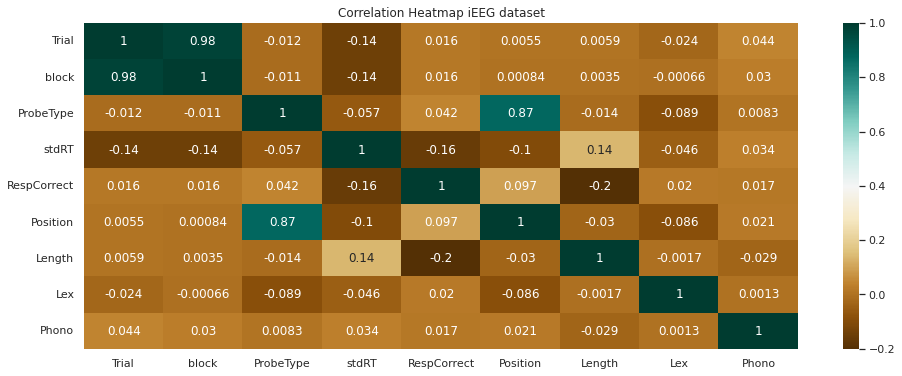

In [ ]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(ieeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


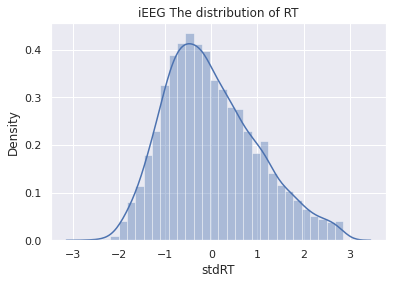

In [ ]:
sns.distplot(ieeg_data.stdRT)
pl.title('iEEG The distribution of RT');

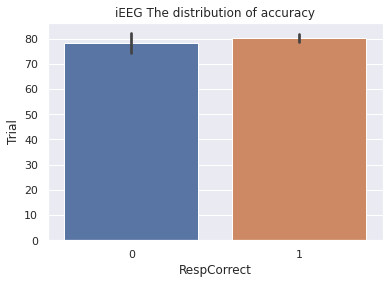

In [ ]:
sns.barplot(
    x = 'RespCorrect', y = 'Trial',
    data = ieeg_data
    )
pl.title('iEEG The distribution of accuracy');

**Models**

In [ ]:
model_fulli = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1138.745 	 AIC: 2277.491

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.114  0.337

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.993   0.940    1.046  0.027  1095.276  36.584  0.000  ***
Lex             0.016  -0.007    0.039  0.012  3317.747   1.364  0.173     
Phono           0.008  -0.015    0.031  0.012  3330.449   0.683  0.494     
Length         -0.031  -0.036   -0.026  0.003  3318.097 -11.904  0.000  ***
ProbeType       0.029   0.006    0.052  0.012  3330.187   2.436  0.015    *

In [ ]:
model_fulli1 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli1.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1146.399 	 AIC: 2292.797

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.937   0.808    1.066  0.066  3220.977  14.262  0.000   
Lex                  0.132   0.034    0.231  0.050  3319.531   2.639  0.008   
Phono               -0.136  -0.235   -0.036  0.051  3315.895  -2.671  0.008   
Length              -0.025  -0.043   -0.007  0.009  3313.369  -2.737  0.006   
ProbeType            0.092   0.018    0.167  0.038  3314.711   2.435  0.015   
Lex:Phono            0.041  -0.005    0.087  0.024  3319.061   1.736  0.083   
Lex:Length           0.001  -0.009    0.011  0.005  3311.754   0.197  0.844   
Lex:ProbeType       -0.098  -0.144   -0.052  0.023  3322.411  -4.154  0.000   
Phono:Length         0.008  -0.003    0.018  0.005  3320.582   1.436  0.151   
Phono:ProbeType      0.052   0.006    0.098  0.024  3312.736   2.210  0.027   
Length:ProbeType    -0.007  -0.018    0.003  0.005  3315.649  -1.372  0.170   

                  Sig  
(Intercept)       ***  
Lex                **  
Phono              **  
Length             **  
ProbeType           *  
Lex:Phono           .  
Lex:Length             
Lex:ProbeType     ***  
Phono:Length           
Phono:ProbeType     *  
Length:ProbeType

In [ ]:
model_fulli2 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Phono*ProbeType + Phono*Length*ProbeType + Lex*Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli2.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Phono*ProbeType+Phono*Length*ProbeType+Lex*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1158.671 	 AIC: 2317.342

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                0.906   0.712    1.100  0.099  3322.168   9.143   
Lex                        0.091  -0.143    0.324  0.119  3309.188   0.761   
Phono                     -0.025  -0.258    0.209  0.119  3313.236  -0.208   
Length                    -0.021  -0.050    0.008  0.015  3310.479  -1.411   
ProbeType                  0.113  -0.009    0.235  0.062  3310.329   1.819   
Lex:Phono                  0.016  -0.175    0.208  0.098  3312.332   0.167   
Lex:Length                 0.010  -0.024    0.043  0.017  3308.996   0.556   
Lex:ProbeType             -0.069  -0.211    0.073  0.073  3308.994  -0.947   
Phono:Length              -0.009  -0.044    0.025  0.018  3311.312  -0.533   
Phono:ProbeType           -0.020  -0.160    0.121  0.072  3310.740  -0.275   
Length:ProbeType          -0.010  -0.028    0.008  0.009  3311.636  -1.073   
Lex:Phono:Length           0.001  -0.019    0.022  0.011  3308.791   0.112   
Lex:Phono:ProbeType        0.012  -0.080    0.105  0.047  3317.973   0.262   
Phono:Length:ProbeType     0.011  -0.010    0.032  0.011  3311.558   1.038   
Lex:Length:ProbeType      -0.006  -0.027    0.015  0.011  3309.193  -0.570   

                        P-val  Sig  
(Intercept)             0.000  ***  
Lex                     0.447       
Phono                   0.835       
Length                  0.158       
ProbeType               0.069    .  
Lex:Phono               0.867       
Lex:Length              0.578       
Lex:ProbeType           0.344       
Phono:Length            0.594       
Phono:ProbeType         0.783       
Length:ProbeType        0.283       
Lex:Phono:Length        0.911       
Lex:Phono:ProbeType     0.794       
Phono:Length:ProbeType  0.299       
Lex:Length:ProbeType    0.569

In [ ]:
model_fulli3 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + ProbeType + Lex*Phono + Lex*Length + Lex*ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + Lex*Phono*Length + Lex*Phono*ProbeType + Phono*Length*ProbeType + Lex*Length*ProbeType + Lex*Phono*Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_fulli3.fit()

Formula: RespCorrect~Lex+Phono+Length+ProbeType+Lex*Phono+Lex*Length+Lex*ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+Lex*Phono*Length+Lex*Phono*ProbeType+Phono*Length*ProbeType+Lex*Length*ProbeType+Lex*Phono*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1161.270 	 AIC: 2322.539

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.113  0.336

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  \
(Intercept)                    0.864   0.645    1.083  0.112  3325.199   
Lex                            0.172  -0.132    0.476  0.155  3315.976   
Phono                          0.054  -0.246    0.353  0.153  3319.287   
Length                        -0.014  -0.048    0.019  0.017  3310.402   
ProbeType                      0.142   0.002    0.282  0.071  3311.578   
Lex:Phono                     -0.138  -0.552    0.277  0.212  3325.205   
Lex:Length                    -0.004  -0.050    0.043  0.024  3315.508   
Lex:ProbeType                 -0.124  -0.318    0.070  0.099  3317.569   
Phono:Length                  -0.022  -0.069    0.024  0.024  3317.296   
Phono:ProbeType               -0.071  -0.259    0.116  0.096  3317.572   
Length:ProbeType              -0.015  -0.036    0.007  0.011  3309.250   
Lex:Phono:Length               0.027  -0.038    0.091  0.033  3322.349   
Lex:Phono:ProbeType            0.117  -0.150    0.384  0.136  3326.599   
Phono:Length:ProbeType         0.020  -0.010    0.049  0.015  3315.302   
Lex:Length:ProbeType           0.003  -0.027    0.033  0.015  3316.860   
Lex:Phono:Length:ProbeType    -0.017  -0.059    0.024  0.021  3324.121   

                            T-stat  P-val  Sig  
(Intercept)                  7.729  0.000  ***  
Lex                          1.109  0.267       
Phono                        0.351  0.725       
Length                      -0.824  0.410       
ProbeType                    1.987  0.047    *  
Lex:Phono                   -0.650  0.516       
Lex:Length                  -0.160  0.873       
Lex:ProbeType               -1.252  0.211       
Phono:Length                -0.945  0.345       
Phono:ProbeType             -0.748  0.455       
Length:ProbeType            -1.342  0.180       
Lex:Phono:Length             0.812  0.417       
Lex:Phono:ProbeType          0.860  0.390       
Phono:Length:ProbeType       1.314  0.189       
Lex:Length:ProbeType         0.204  0.839       
Lex:Phono:Length:ProbeType  -0.820  0.412

**Without match/mismatch**

In [ ]:
model_noprobe_i = Lmer(
    'RespCorrect ~ Lex + Phono + Length + (1|Subject)',
    data = ieeg_data
)
model_noprobe_i.fit()

Formula: RespCorrect~Lex+Phono+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1138.186 	 AIC: 2276.372

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.037   0.997    1.077  0.020   430.581  50.967  0.000  ***
Lex             0.013  -0.009    0.036  0.012  3318.771   1.151  0.250     
Phono           0.008  -0.015    0.031  0.012  3331.334   0.708  0.479     
Length         -0.031  -0.036   -0.026  0.003  3319.051 -11.932  0.000  ***

In [ ]:
model_noprobe_i1 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + (1|Subject)',
    data = ieeg_data
)
model_noprobe_i1.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1147.874 	 AIC: 2295.747

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)      1.075   1.013    1.138  0.032  1640.731  33.648  0.000  ***
Lex             -0.020  -0.090    0.051  0.036  3316.735  -0.547  0.585     
Phono           -0.048  -0.118    0.022  0.036  3323.988  -1.344  0.179     
Length          -0.036  -0.045   -0.027  0.005  3319.286  -7.706  0.000  ***
Lex:Phono        0.032  -0.014    0.078  0.023  3322.626   1.350  0.177     
Lex:Length       0.003  -0.008    0.013  0.005  3315.803   0.508  0.611     
Phono:Length     0.007  -0.004    0.017  0.005  3323.930   1.278  0.201

In [ ]:
model_noprobe_i2 = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)',
    data = ieeg_data
)
model_noprobe_i2.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3343	 Groups: {'Subject': 22.0}

Log-likelihood: -1151.512 	 AIC: 2303.023

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.035
Residual               0.114  0.338

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.075   1.003    1.146  0.037  2115.234  29.427  0.000   
Lex                 -0.019  -0.116    0.079  0.050  3315.848  -0.375  0.708   
Phono               -0.047  -0.140    0.047  0.048  3319.285  -0.983  0.326   
Length              -0.036  -0.047   -0.025  0.006  3316.597  -6.539  0.000   
Lex:Phono            0.030  -0.102    0.161  0.067  3316.658   0.439  0.661   
Lex:Length           0.002  -0.013    0.017  0.008  3315.089   0.322  0.747   
Phono:Length         0.007  -0.008    0.021  0.007  3318.223   0.879  0.379   
Lex:Phono:Length     0.000  -0.020    0.021  0.010  3315.433   0.034  0.973   

                  Sig  
(Intercept)       ***  
Lex                    
Phono                  
Length            ***  
Lex:Phono              
Lex:Length             
Phono:Length           
Lex:Phono:Length

**Model with Match vs. Mismatch**

In [ ]:
match_i = ieeg_data[ieeg_data['ProbeType'] == 2]
mismatch_i = ieeg_data[ieeg_data['ProbeType'] == 1]

In [ ]:
# model for MATCH
model_matchi = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)',
    data = match_i
)
model_matchi.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1575	 Groups: {'Subject': 22.0}

Log-likelihood: -442.880 	 AIC: 885.761

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.005  0.068
Residual               0.098  0.312

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.145   1.047    1.243  0.050   917.447  22.935  0.000   
Lex                 -0.056  -0.186    0.074  0.066  1551.072  -0.848  0.396   
Phono               -0.080  -0.201    0.040  0.062  1547.936  -1.303  0.193   
Length              -0.044  -0.058   -0.029  0.007  1546.379  -5.938  0.000   
Lex:Phono            0.049  -0.132    0.229  0.092  1557.925   0.527  0.598   
Lex:Length          -0.000  -0.021    0.020  0.010  1550.400  -0.037  0.970   
Phono:Length         0.016  -0.003    0.035  0.010  1546.957   1.683  0.093   
Lex:Phono:Length    -0.002  -0.030    0.026  0.014  1554.549  -0.137  0.891   

                  Sig  
(Intercept)       ***  
Lex                    
Phono                  
Length            ***  
Lex:Phono              
Lex:Length             
Phono:Length        .  
Lex:Phono:Length

In [ ]:
# model for MISMATCH
model_mismatchi = Lmer(
    'RespCorrect ~ Lex + Phono + Length + Lex*Phono + Lex*Length + Phono*Length + Lex*Phono*Length + (1|Subject)',
    data = mismatch_i
)
model_mismatchi.fit()

Formula: RespCorrect~Lex+Phono+Length+Lex*Phono+Lex*Length+Phono*Length+Lex*Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1768	 Groups: {'Subject': 22.0}

Log-likelihood: -690.641 	 AIC: 1381.281

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.050
Residual               0.123  0.351

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.998   0.894    1.101  0.053  1373.595  18.932  0.000   
Lex                  0.059  -0.082    0.200  0.072  1744.219   0.823  0.410   
Phono               -0.000  -0.141    0.140  0.072  1752.019  -0.006  0.995   
Length              -0.028  -0.043   -0.012  0.008  1743.511  -3.518  0.000   
Lex:Phono           -0.046  -0.237    0.145  0.097  1750.809  -0.473  0.636   
Lex:Length          -0.002  -0.024    0.019  0.011  1743.642  -0.208  0.835   
Phono:Length        -0.005  -0.027    0.016  0.011  1750.360  -0.492  0.623   
Lex:Phono:Length     0.013  -0.017    0.042  0.015  1748.157   0.837  0.402   

                  Sig  
(Intercept)       ***  
Lex                    
Phono                  
Length            ***  
Lex:Phono              
Lex:Length             
Phono:Length           
Lex:Phono:Length

**Model with Words vs. Non-words**

In [ ]:
words_i = ieeg_data[ieeg_data['Lex'] == 1]
nonwords_i = ieeg_data[ieeg_data['Lex'] == 0]

In [ ]:
model_wordsi = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + (1|Subject)',
    data = words_i
)
model_wordsi.fit()

Formula: RespCorrect~Phono+ProbeType+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1675	 Groups: {'Subject': 22.0}

Log-likelihood: -536.078 	 AIC: 1072.155

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.052
Residual               0.108  0.328

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.069   0.998    1.139  0.036   678.244  29.560   0.00  ***
Phono           0.024  -0.008    0.055  0.016  1652.374   1.478   0.14     
ProbeType      -0.023  -0.055    0.009  0.016  1667.116  -1.407   0.16     
Length         -0.030  -0.037   -0.023  0.004  1650.681  -8.382   0.00  ***

In [ ]:
model_nonwordsi = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + (1|Subject)',
    data = nonwords_i
)
model_nonwordsi.fit()

Formula: RespCorrect~Phono+ProbeType+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1668	 Groups: {'Subject': 22.0}

Log-likelihood: -598.277 	 AIC: 1196.553

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.117  0.343

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.937   0.865    1.010  0.037  1113.236  25.316  0.000  ***
Phono          -0.013  -0.046    0.020  0.017  1662.917  -0.766  0.444     
ProbeType       0.077   0.044    0.110  0.017  1647.180   4.597  0.000  ***
Length         -0.032  -0.040   -0.025  0.004  1644.197  -8.590  0.000  ***

In [ ]:
model_wordsi1 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + (1|Subject)',
    data = words_i
)
model_wordsi1.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1675	 Groups: {'Subject': 22.0}

Log-likelihood: -543.525 	 AIC: 1087.049

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.052
Residual               0.108  0.328

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.048   0.885    1.210  0.083  1638.434  12.633  0.000   
Phono               -0.099  -0.229    0.032  0.067  1648.830  -1.480  0.139   
ProbeType            0.012  -0.086    0.110  0.050  1648.990   0.243  0.808   
Length              -0.020  -0.043    0.004  0.012  1649.822  -1.664  0.096   
Phono:ProbeType      0.052  -0.012    0.116  0.033  1654.854   1.584  0.113   
Phono:Length         0.008  -0.006    0.023  0.007  1653.450   1.157  0.247   
ProbeType:Length    -0.011  -0.025    0.004  0.007  1650.557  -1.468  0.142   

                  Sig  
(Intercept)       ***  
Phono                  
ProbeType              
Length              .  
Phono:ProbeType        
Phono:Length           
ProbeType:Length

In [ ]:
model_nonwordsi1 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + (1|Subject)',
    data = nonwords_i
)
model_nonwordsi1.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1668	 Groups: {'Subject': 22.0}

Log-likelihood: -607.418 	 AIC: 1214.835

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.033
Residual               0.117  0.343

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.960   0.792    1.128  0.086  1657.786  11.197  0.000   
Phono               -0.117  -0.256    0.022  0.071  1649.883  -1.653  0.099   
ProbeType            0.076  -0.026    0.178  0.052  1641.534   1.458  0.145   
Length              -0.030  -0.055   -0.006  0.012  1641.567  -2.435  0.015   
Phono:ProbeType      0.043  -0.023    0.109  0.034  1646.497   1.264  0.206   
Phono:Length         0.007  -0.008    0.021  0.008  1646.238   0.869  0.385   
ProbeType:Length    -0.004  -0.018    0.011  0.008  1643.009  -0.477  0.633   

                  Sig  
(Intercept)       ***  
Phono               .  
ProbeType              
Length              *  
Phono:ProbeType        
Phono:Length           
ProbeType:Length

In [ ]:
model_wordsi2 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + Phono*ProbeType*Length + (1|Subject)',
    data = words_i
)
model_wordsi2.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+Phono*ProbeType*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1675	 Groups: {'Subject': 22.0}

Log-likelihood: -546.740 	 AIC: 1093.481

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.052
Residual               0.108  0.328

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                1.021   0.814    1.229  0.106  1662.022   9.643   
Phono                     -0.047  -0.328    0.233  0.143  1659.778  -0.332   
ProbeType                  0.030  -0.101    0.162  0.067  1654.757   0.450   
Length                    -0.015  -0.047    0.016  0.016  1654.607  -0.956   
Phono:ProbeType            0.016  -0.170    0.202  0.095  1663.565   0.169   
Phono:Length              -0.000  -0.043    0.043  0.022  1656.136  -0.002   
ProbeType:Length          -0.014  -0.034    0.007  0.010  1657.826  -1.317   
Phono:ProbeType:Length     0.006  -0.023    0.035  0.015  1660.467   0.404   

                        P-val  Sig  
(Intercept)             0.000  ***  
Phono                   0.740       
ProbeType               0.653       
Length                  0.339       
Phono:ProbeType         0.866       
Phono:Length            0.998       
ProbeType:Length        0.188       
Phono:ProbeType:Length  0.686

In [ ]:
model_nonwordsi2 = Lmer(
    'RespCorrect ~ Phono + ProbeType + Length + Phono*ProbeType + Phono*Length + ProbeType*Length + ProbeType*Length*Phono + (1|Subject)',
    data = nonwords_i
)
model_nonwordsi2.fit()

Formula: RespCorrect~Phono+ProbeType+Length+Phono*ProbeType+Phono*Length+ProbeType*Length+ProbeType*Length*Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1668	 Groups: {'Subject': 22.0}

Log-likelihood: -609.664 	 AIC: 1219.327

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.034
Residual               0.117  0.342

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                0.853   0.630    1.076  0.114  1659.995   7.495   
Phono                      0.081  -0.224    0.386  0.156  1656.140   0.523   
ProbeType                  0.149   0.006    0.291  0.073  1646.604   2.044   
Length                    -0.013  -0.047    0.021  0.017  1644.982  -0.733   
Phono:ProbeType           -0.088  -0.279    0.103  0.097  1654.219  -0.905   
Phono:Length              -0.026  -0.074    0.021  0.024  1653.910  -1.088   
ProbeType:Length          -0.015  -0.037    0.006  0.011  1643.360  -1.381   
Phono:ProbeType:Length     0.022  -0.008    0.051  0.015  1651.487   1.432   

                        P-val  Sig  
(Intercept)             0.000  ***  
Phono                   0.601       
ProbeType               0.041    *  
Length                  0.464       
Phono:ProbeType         0.366       
Phono:Length            0.277       
ProbeType:Length        0.168       
Phono:ProbeType:Length  0.152

**Model with H vs. L**

In [ ]:
high_i = ieeg_data[ieeg_data['Phono'] == 0]
low_i = ieeg_data[ieeg_data['Phono'] == 1]

In [ ]:
model_highi = Lmer(
    'RespCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Length*ProbeType + Length*Lex + Length*Lex*ProbeType + (1|Subject)',
    data = high_i
)
model_highi.fit()

Formula: RespCorrect~Lex+ProbeType+Length+Lex*ProbeType+Length*ProbeType+Length*Lex+Length*Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1545	 Groups: {'Subject': 22.0}

Log-likelihood: -562.410 	 AIC: 1124.820

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.002  0.043
Residual               0.116  0.341

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)              0.866   0.644    1.089  0.114  1536.739   7.632   
Lex                      0.167  -0.141    0.476  0.158  1527.161   1.063   
ProbeType                0.141  -0.001    0.282  0.072  1521.881   1.942   
Length                  -0.014  -0.048    0.020  0.017  1520.551  -0.827   
Lex:ProbeType           -0.121  -0.318    0.076  0.101  1528.978  -1.204   
ProbeType:Length        -0.015  -0.036    0.007  0.011  1519.204  -1.309   
Lex:Length              -0.003  -0.051    0.044  0.024  1526.797  -0.137   
Lex:ProbeType:Length     0.003  -0.028    0.033  0.016  1528.330   0.179   

                      P-val  Sig  
(Intercept)           0.000  ***  
Lex                   0.288       
ProbeType             0.052    .  
Length                0.408       
Lex:ProbeType         0.229       
ProbeType:Length      0.191       
Lex:Length            0.891       
Lex:ProbeType:Length  0.858

In [ ]:
model_lowi = Lmer(
    'RespCorrect ~ Lex + ProbeType + Length + Lex*ProbeType + Length*ProbeType + Length*Lex + Length*Lex*ProbeType + (1|Subject)',
    data = low_i
)
model_lowi.fit()

Formula: RespCorrect~Lex+ProbeType+Length+Lex*ProbeType+Length*ProbeType+Length*Lex+Length*Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1798	 Groups: {'Subject': 22.0}

Log-likelihood: -600.396 	 AIC: 1200.791

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.024
Residual               0.111  0.333

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)              0.926   0.724    1.128  0.103  1789.480   8.987   
Lex                      0.020  -0.258    0.297  0.142  1789.923   0.139   
ProbeType                0.065  -0.057    0.188  0.063  1783.102   1.044   
Length                  -0.038  -0.070   -0.006  0.016  1784.013  -2.335   
Lex:ProbeType            0.003  -0.178    0.183  0.092  1789.652   0.029   
ProbeType:Length         0.005  -0.014    0.025  0.010  1782.905   0.554   
Lex:Length               0.025  -0.019    0.069  0.022  1786.272   1.112   
Lex:ProbeType:Length    -0.016  -0.044    0.013  0.014  1787.854  -1.078   

                      P-val  Sig  
(Intercept)           0.000  ***  
Lex                   0.890       
ProbeType             0.297       
Length                0.020    *  
Lex:ProbeType         0.977       
ProbeType:Length      0.580       
Lex:Length            0.266       
Lex:ProbeType:Length  0.281

(0.775, 0.975)

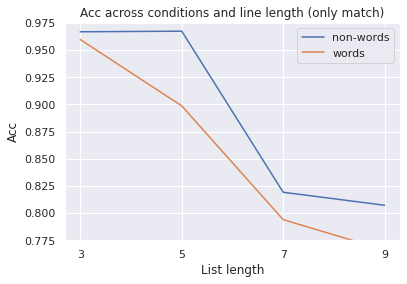

(0.775, 0.975)

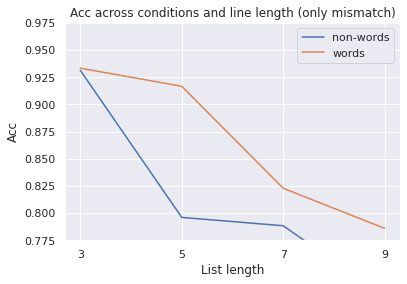

In [ ]:
pl.figure()
subset = ieeg_short[ieeg_short['ProbeType'] == 1] # mismatch
subset = subset.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.RespCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across conditions and line length (only mismatch)');
pl.ylim([0.775, 0.975])

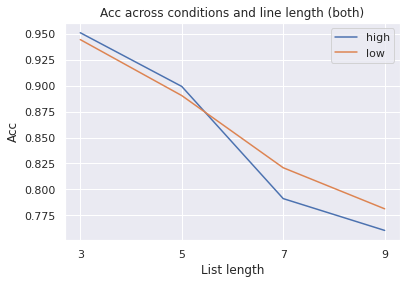

In [ ]:
pl.figure()
subset = ieeg_short.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'high')
  elif i == 1:
      pl.plot(x.Length, x.RespCorrect, label = 'low')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across conditions and line length (both)');

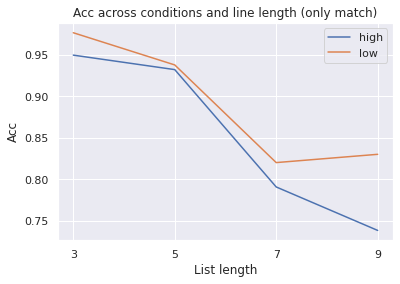

In [ ]:
pl.figure()
match = ieeg_short[ieeg_short['ProbeType'] == 2] # match
subset = match.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'high')
  elif i == 1:
      pl.plot(x.Length, x.RespCorrect, label = 'low')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across conditions and line length (only match)');

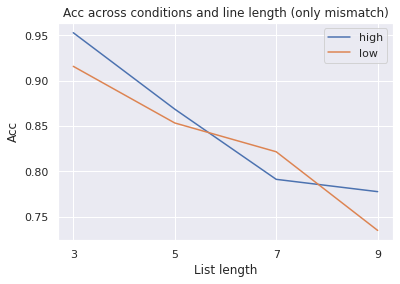

In [ ]:
pl.figure()
mismatch = ieeg_short[ieeg_short['ProbeType'] == 1] # mismatch
subset = mismatch.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'high')
  elif i == 1:
    pl.plot(x.Length, x.RespCorrect, label = 'low')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Acc across conditions and line length (only mismatch)');

In [ ]:
pl.figure()
pl.plo

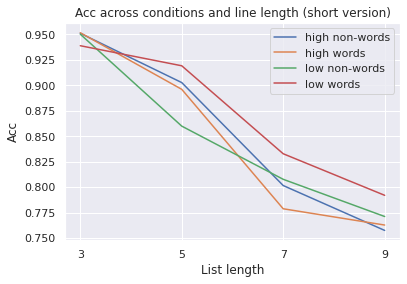

In [ ]:
pl.figure()
subset = ieeg_short.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length (short version)');

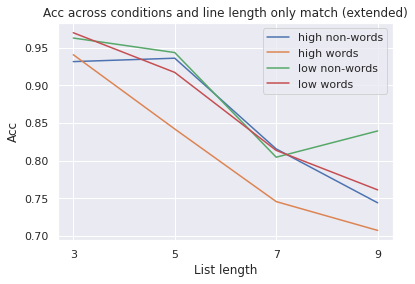

In [ ]:
# WHEN MATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = match_.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only match (extended)');

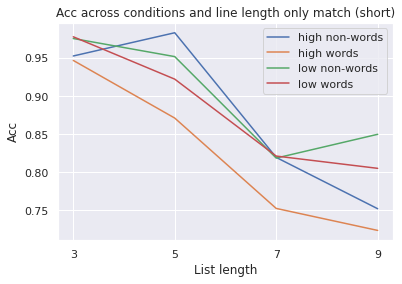

In [ ]:
# WHEN MATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = match_short.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only match (short)');

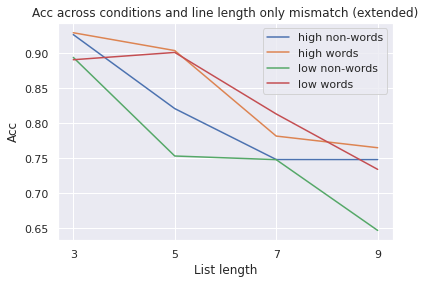

In [ ]:
# WHEN MISMATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = mismatch_.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only mismatch (extended)');

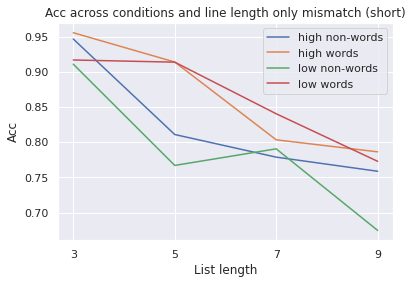

In [ ]:
# WHEN MISMATCH
# percentages of correct responses for different conditions
# acc = correct trials in this cond / all trials in this cond
pl.figure()
subset = mismatch_short.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length only mismatch (short)');

### iEEG dataset

## Preprocessing of the iEEG dataset



1.   a lot of outliers and no response trials for D54: 50 % are either outliers or no response trials 
2.   7 subject below 75% threshold. 70% - 4. If we count no response trials as INCORRECT. 
3.   After this, outliers and no response are no greater than 10% of data. 75 no response and 79 outliers overall



In [104]:
ieeg_no_trials = ieeg[ieeg['Resp'] != 'No Response']
print('The shape of the iEEG dataset with "No Response" trials', ieeg.shape)
print('The accuracy', ieeg.RespCorrect.mean())
print('The shape of the iEEG dataset without "No Response" trials', ieeg_no_trials.shape)
print('The accuracy', ieeg_no_trials.RespCorrect.mean())

The shape of the iEEG dataset with "No Response" trials (4980, 20)
The accuracy 0.7917670682730924
The shape of the iEEG dataset without "No Response" trials (4767, 20)
The accuracy 0.8271449548982589


In [99]:
checkset1 = ieeg.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
checkset2 = ieeg_no_trials.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)

In [105]:
options_drop1 = checkset1[checkset1['RespCorrect'] < 0.75].index
new1 = checkset1.reset_index()
print('The subjects with accuracy less than 75 %')
print('The dataset with "No response" trials')
print(options_drop1)
x1 = []
for i in new1.Subject.values:
  for j in options_drop1:
    if i == j:
      x1.append(new1.loc[new1['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg1 = ieeg[
                        (ieeg['Subject'] != 'D30') &
                        (ieeg['Subject'] != 'D33') &
                        (ieeg['Subject'] != 'D49') &
                        (ieeg['Subject'] != 'D54') &
                        (ieeg['Subject'] != 'D61') &
                        (ieeg['Subject'] != 'D65') &
                        (ieeg['Subject'] != 'D70')
                        ]
print('Poor performers', len(options_drop1))
print('Accuracy without poor performers', ieeg1.RespCorrect.mean())
print('')

options_drop1 = checkset1[checkset1['RespCorrect'] < 0.70].index
new2 = checkset1.reset_index()
print('The subjects with accuracy less than 70 %')
print('The dataset with "No response" trials')
print(options_drop1)
x1 = []
for i in new2.Subject.values:
  for j in options_drop1:
    if i == j:
      x1.append(new2.loc[new2['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg2 = ieeg[
                        (ieeg['Subject'] != 'D33') &
                        (ieeg['Subject'] != 'D49') &
                        (ieeg['Subject'] != 'D54') &
                        (ieeg['Subject'] != 'D61') &
                        (ieeg['Subject'] != 'D65')                       
                        ]
print('Poor performers', len(options_drop1))
print('Accuracy without poor performers', ieeg2.RespCorrect.mean())
print('')

options_drop2 = checkset2[checkset2['RespCorrect'] < 0.75].index
new3 = checkset2.reset_index()
print('The subjects with accuracy less than 75 %')
print('The dataset without "No response" trials')
print(options_drop2)
x1 = []
for i in new3.Subject.values:
  for j in options_drop2:
    if i == j:
      x1.append(new3.loc[new3['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg3 = ieeg_no_trials[
                        (ieeg_no_trials['Subject'] != 'D30') &
                        (ieeg_no_trials['Subject'] != 'D33') &
                        (ieeg_no_trials['Subject'] != 'D49') &
                        (ieeg_no_trials['Subject'] != 'D54') &
                        (ieeg_no_trials['Subject'] != 'D61') &
                        (ieeg_no_trials['Subject'] != 'D65')                        
                        ]
print('Poor performers', len(options_drop2))
print('Accuracy without poor performers', ieeg3.RespCorrect.mean())
print('')

options_drop2 = checkset2[checkset2['RespCorrect'] < 0.70].index
new4 = checkset2.reset_index()
print('The subjects with accuracy less than 70 %')
print('The dataset without "No response" trials')
print(options_drop2)
x1 = []
for i in new4.Subject.values:
  for j in options_drop2:
    if i == j:
      x1.append(new4.loc[new4['Subject'] == i][['RespCorrect']].values[0][0])
print(x1)
ieeg4 = ieeg_no_trials[
                        (ieeg_no_trials['Subject'] != 'D33') &
                        (ieeg_no_trials['Subject'] != 'D49') &
                        (ieeg_no_trials['Subject'] != 'D61')
                        ]
print('Poor performers', len(options_drop2))
print('Accuracy without poor performers', ieeg4.RespCorrect.mean())

The subjects with accuracy less than 75 %
The dataset with "No response" trials
Index(['D30', 'D33', 'D49', 'D54', 'D61', 'D65', 'D70'], dtype='object', name='Subject')
[0.70625, 0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65, 0.71875]
Poor performers 7
Accuracy without poor performers 0.8418992955909209

The subjects with accuracy less than 70 %
The dataset with "No response" trials
Index(['D33', 'D49', 'D54', 'D61', 'D65'], dtype='object', name='Subject')
[0.6310160427807486, 0.61875, 0.43125, 0.6125, 0.65]
Poor performers 5
Accuracy without poor performers 0.8319287262220082

The subjects with accuracy less than 75 %
The dataset without "No response" trials
Index(['D30', 'D33', 'D49', 'D54', 'D61', 'D65'], dtype='object', name='Subject')
[0.7483443708609272, 0.6941176470588235, 0.6470588235294118, 0.7419354838709677, 0.6666666666666666, 0.7272727272727273]
Poor performers 6
Accuracy without poor performers 0.8547314578005115

The subjects with accuracy less than 70 %
The dataset

In [116]:
ieeg_ = ieeg2[ieeg2['Resp'] != 'No Response']

**Looking into outliers**

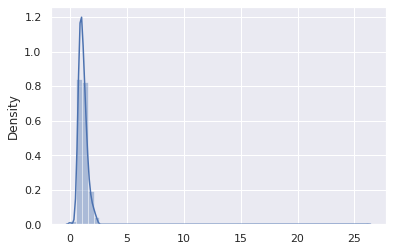

In [117]:
sns.distplot(ieeg_['ReactionTime'].values);

In [122]:
print('In seconds')
print(
    'mean', ieeg_.ReactionTime.mean(),
    'max', ieeg_.ReactionTime.max(),
    'min', ieeg_.ReactionTime.min())

In seconds
mean 1.167111511337368 max 26.11535499338061 min 0.0163338184356689


In [169]:
# kicking out all the trials (11) that are below 150 msec
ieeg_no_outliers = ieeg_[ieeg_['ReactionTime'] > 0.15]

In [176]:
# kicking out the trial of 26 sec
ieeg_no_outliers = ieeg_no_outliers[ieeg_no_outliers['ReactionTime'] < 25]

D23 Max 1.9540013382211328 Min 0.5284106724429876
D26 Max 2.248248639079975 Min 0.7032921151840128
D27 Max 2.370206625200808 Min 0.8089978282805532
D28 Max 1.9540013382211328 Min 0.5284106724429876
D29 Max 2.390633505769074 Min 0.7759903273545206
D30 Max 2.322723206569208 Min 0.6001890921761515
D31 Max 2.385297764209099 Min 1.010608747776132
D34 Max 1.551644212071551 Min 0.3314915607334114
D35 Max 1.970156551338732 Min 0.4253534044255502
D36 Max 2.415138150442999 Min 0.5638364125347834
D38 Max 2.175345399067737 Min 0.6113873518770561
D39 Max 2.164169502793812 Min 0.7234540177159943
D41 Max 2.1313432455062866 Min 0.7655674288980663
D42 Max 2.317979554645717 Min 0.8343088356778026
D47 Max 2.3508441991143627 Min 0.9056599745672428
D48 Max 2.4882030544395093 Min 0.6624780359707074
D53 Max 2.2486149263568223 Min 0.7813855952117592
D55 Max 2.351802069984842 Min 0.6055784318014048
D57 Max 2.064570903778076 Min 0.5506687164306641
D59 Max 1.98850679397583 Min 0.7078800201416016
D63 Max 2.432389

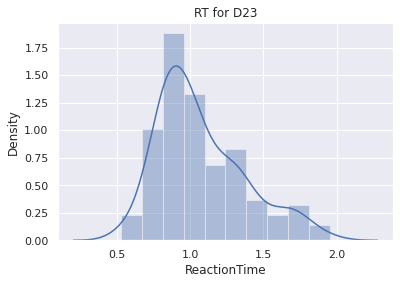

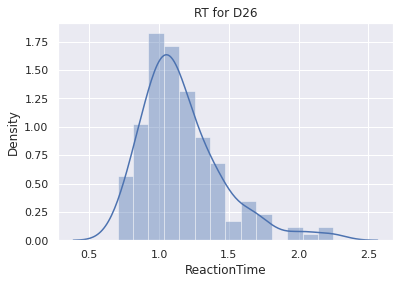

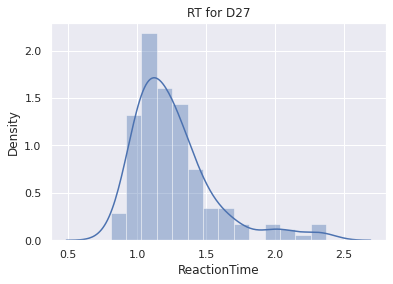

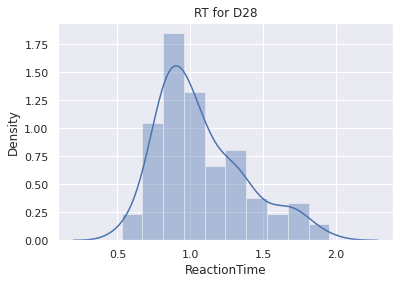

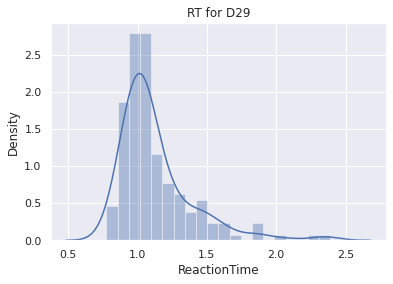

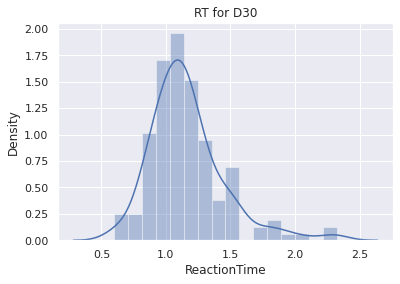

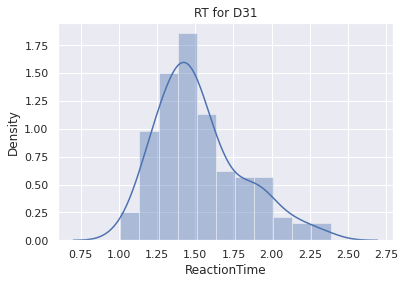

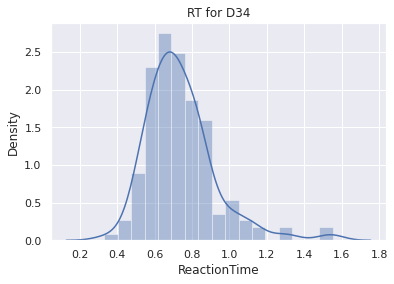

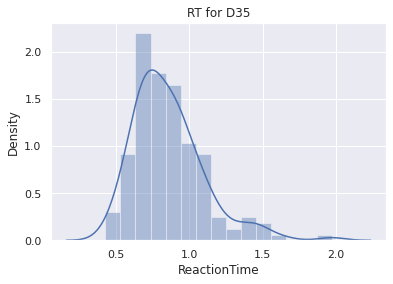

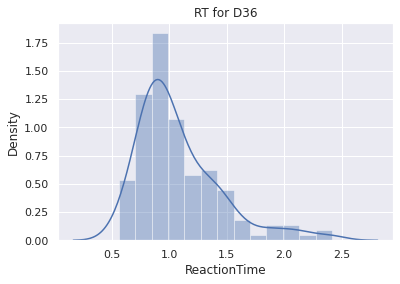

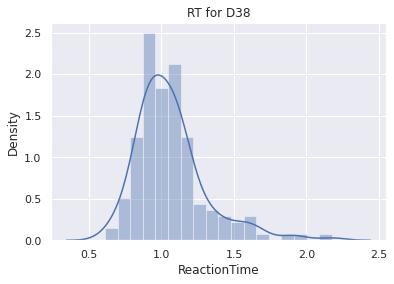

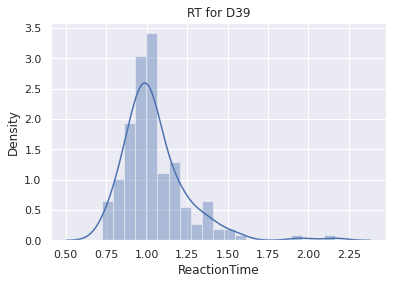

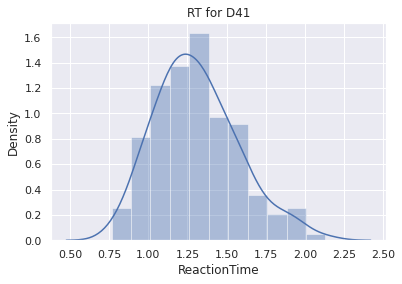

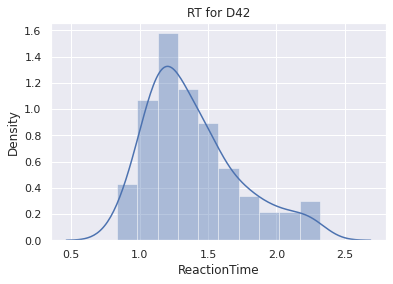

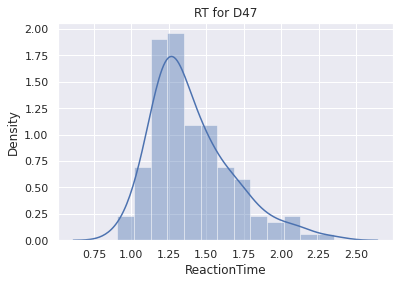

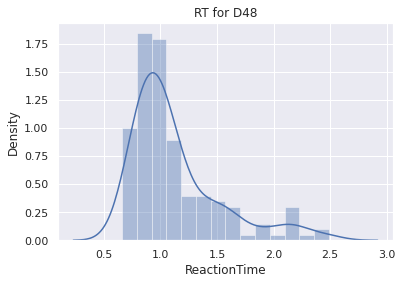

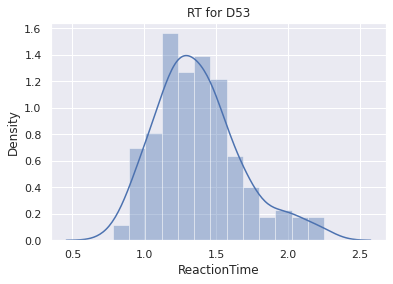

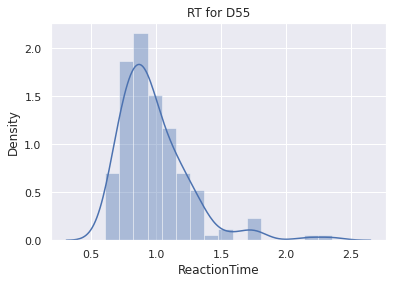

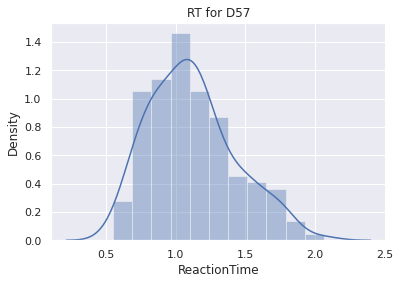

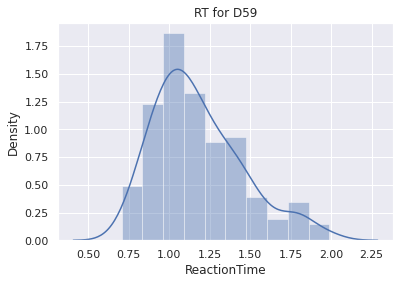

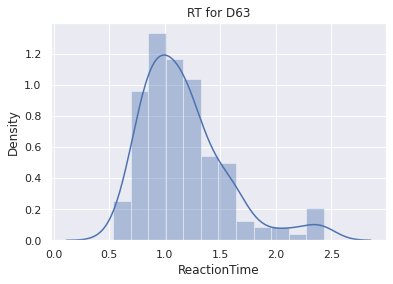

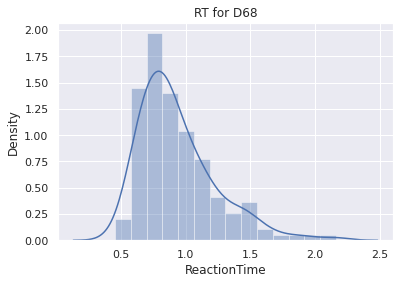

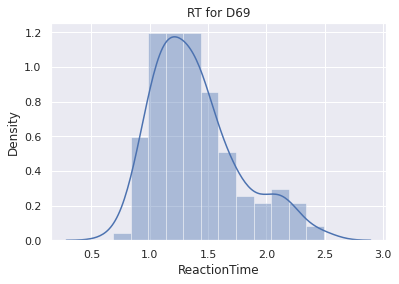

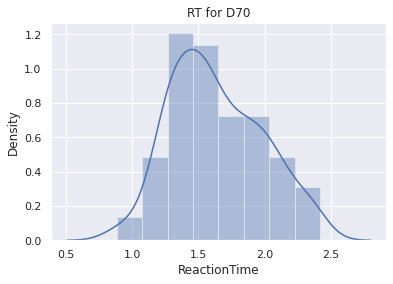

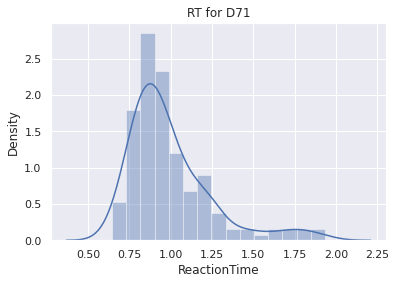

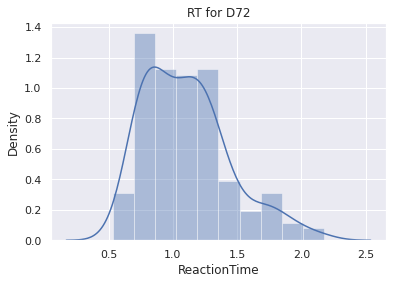

In [179]:
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  pl.figure()
  sns.distplot(subset.ReactionTime)
  pl.title('RT for ' + i);
  print(i, 'Max', subset.ReactionTime.max(), 'Min', subset.ReactionTime.min())

Mean 1.1640103424767825 Max 2.490496158599853 Min 0.3314915607334114


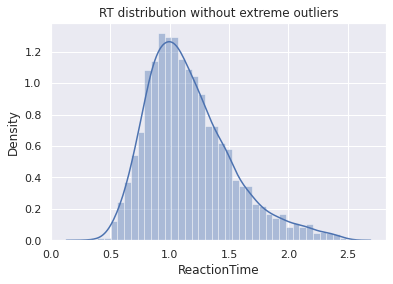

In [185]:
sns.distplot(ieeg_no_outliers.ReactionTime)
pl.title('RT distribution without extreme outliers');
print(
    'Mean', ieeg_no_outliers.ReactionTime.mean(),
    'Max', ieeg_no_outliers.ReactionTime.max(),
    'Min', ieeg_no_outliers.ReactionTime.min()
)

In [199]:
values = []
for i in ieeg_no_outliers.Subject.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Subject'] == i]
  q75 = np.percentile(subset['ReactionTime'], 75)
  q25 = np.percentile(subset['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset.ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

D23 0
D26 2
D27 3
D28 0
D29 3
D30 2
D31 0
D34 2
D35 1
D36 0
D38 3
D39 2
D41 0
D42 0
D47 0
D48 3
D53 0
D55 2
D57 0
D59 0
D63 0
D68 1
D69 0
D70 0
D71 3
D72 0


In [200]:
len(values)

27

In [208]:
# recalculating stdRT
rts = ieeg_no_outliers['ReactionTime'].values
ieeg_no_outliers['stdRT'] = (ieeg_no_outliers['ReactionTime'] - rts.mean())/rts.std()

## Accuracy plots iEEG dataset w/out No response trials

**PLOTS**

BOTH MATCH AND MISMATCH

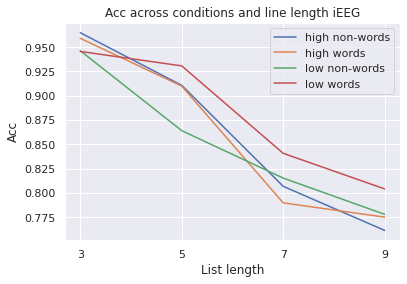

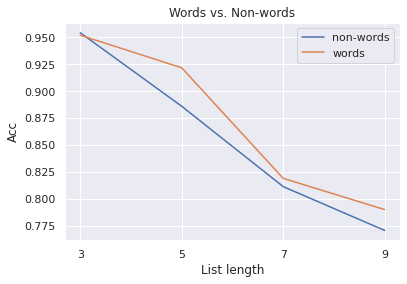

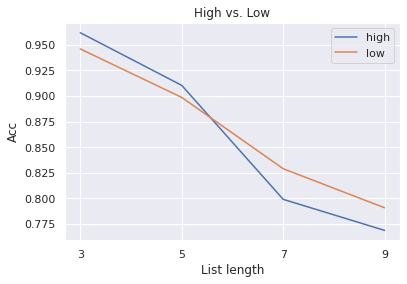

In [225]:
ieeg_subset = ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'No Response']

pl.figure()
subset = ieeg_subset.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length iEEG');

pl.figure()
subset = ieeg_subset.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words');

pl.figure()
subset = ieeg_subset.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low');

ONLY MATCH

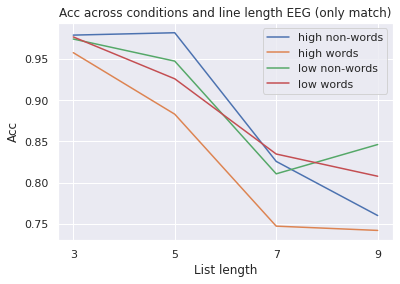

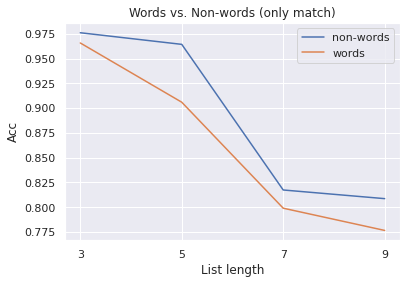

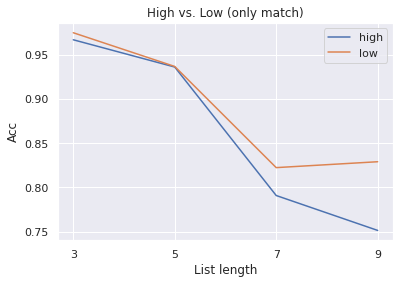

In [226]:
only_match = ieeg_subset[ieeg_subset['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only match)');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'non-words')
  elif i == 1:
    pl.plot(x.Length, x.RespCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match)');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match)');

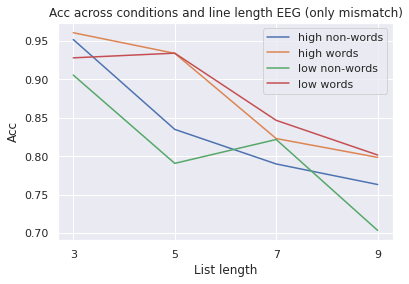

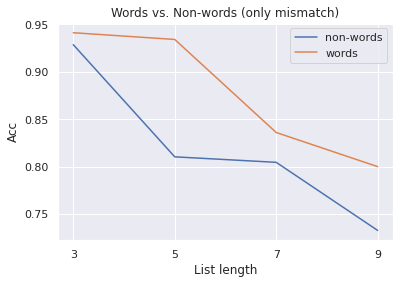

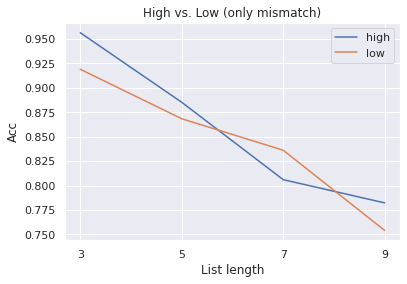

In [227]:
only_mismatch = ieeg_subset[ieeg_subset['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch)');

MATCH AND MISMATCH ON THE SAME PLOT

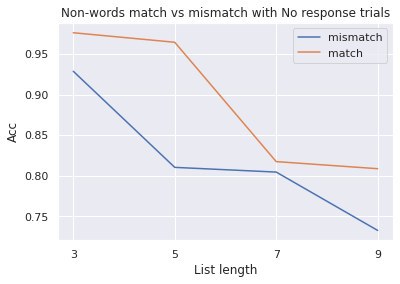

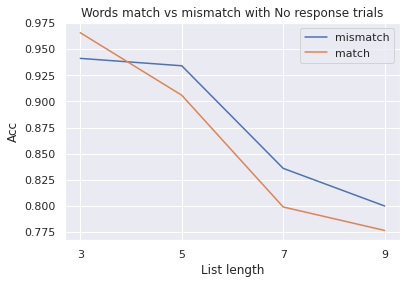

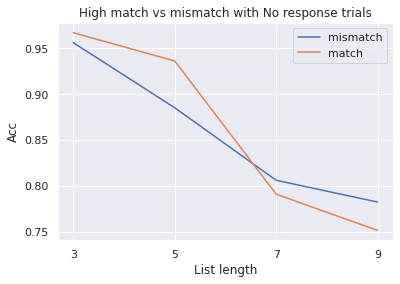

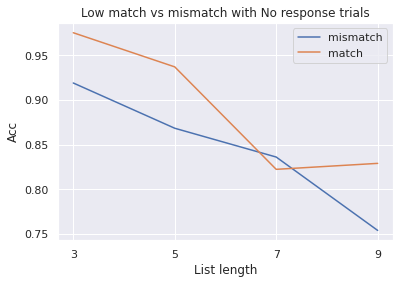

In [228]:
pl.figure()
nonwords = ieeg_subset[ieeg_subset['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch with No response trials');

pl.figure()
words = ieeg_subset[ieeg_subset['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch with No response trials');

pl.figure()
high = ieeg_subset[ieeg_subset['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch with No response trials');

pl.figure()
low = ieeg_subset[ieeg_subset['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch with No response trials');

## Accuracy bar plots

In [210]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

P-value 0.5271815031643929
H 0.8482758620689655 L 0.8553604436229205


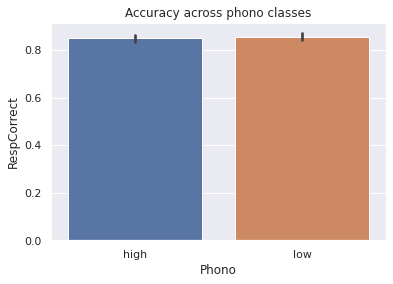

In [212]:
# W vs NW
pl.figure()
fig = sns.barplot('Phono', 'RespCorrect', data=ieeg_no_outliers)
fig.set_xticklabels(['high', 'low'])
pl.title('Accuracy across phono classes');

x, y = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]['RespCorrect'].values, ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]['RespCorrect'].values
print('P-value', ttest(x, y)[1])
print('H', y.mean(), 'L', x.mean())

P-value for words 0.2036088121821598
H 0.8472222222222222 L 0.8670944087992667
P-value for non-words 0.7141954851615668
H 0.8493150684931506 L 0.8434296365330848


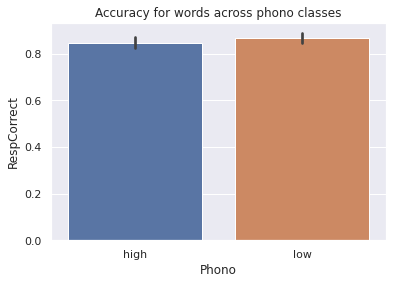

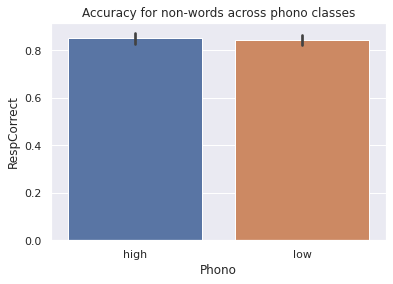

In [213]:
# W H vs L, NW H vs L
for i in ieeg_no_outliers.Lex.unique():
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.figure()
  subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == i]
  fig = sns.barplot('Phono', 'RespCorrect', data=subset)
  fig.set_xticklabels(['high', 'low'])
  pl.title('Accuracy for ' + name + ' across phono classes');

  x, y = subset[subset['Phono'] == 1]['RespCorrect'].values, subset[subset['Phono'] == 0]['RespCorrect'].values
  print('P-value for', name, ttest(x, y)[1])
  print('H', y.mean(), 'L', x.mean())

P-value for words match 0.13707792891789844
H 0.8306264501160093 L 0.8663793103448276
P-value for words mismatch 0.7610186359604696
H 0.8613861386138614 L 0.8676236044657097
P-value for non-words match 0.38378758509780253
H 0.8763796909492274 L 0.8939130434782608
P-value for non-words mismatch 0.11674656228576161
H 0.8245967741935484 L 0.785140562248996


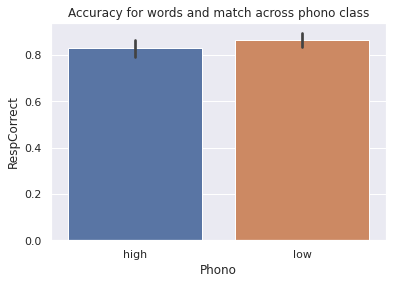

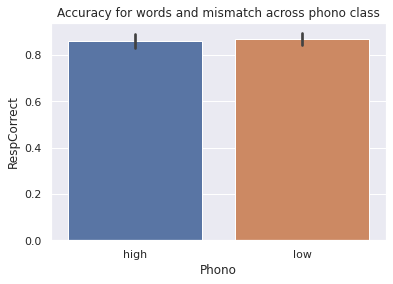

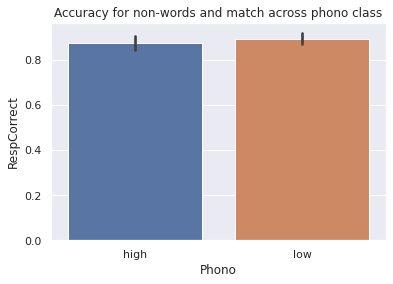

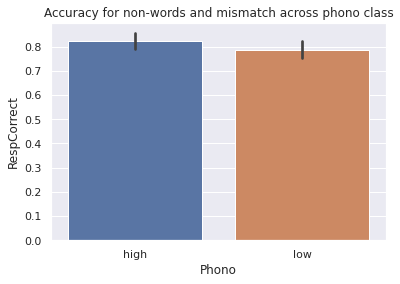

In [214]:
# 1/ W MATCH H vs L, 2/ W MISMATCH H vs L 
# 3/ NW MATCH H vs L, 4/ NW MISMATCH H vs L
for lex_class in ieeg_no_outliers.Lex.unique():
  if lex_class == 0:
    name1 = 'non-words'
  elif lex_class == 1:
    name1 = 'words'
  subset = ieeg_no_outliers[ieeg_no_outliers['Lex'] == lex_class]
  for probe_class in subset.ProbeType.unique():
    if probe_class == 1:
      name2 = 'mismatch'
    elif probe_class == 2:
      name2 = 'match'
    ss = subset[subset['ProbeType'] == probe_class]

    pl.figure()
    fig = sns.barplot('Phono', 'RespCorrect', data=ss)
    fig.set_xticklabels(['high', 'low'])
    pl.title(
        'Accuracy for ' + name1 + ' and ' + name2 + ' across phono class'
    );

    x, y = ss[ss['Phono'] == 1]['RespCorrect'].values, ss[ss['Phono'] == 0]['RespCorrect'].values
    print('P-value for', name1, name2, ttest(x, y)[1])
    print('H', y.mean(), 'L', x.mean())

In [215]:
for i in ieeg_no_outliers.Length.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == i] 
  x, y = subset[subset['Phono'] == 1]['RespCorrect'].values, subset[subset['Phono'] == 0]['RespCorrect'].values
  print('P-value for', i, ttest(x, y)[1])
  print('H', y.mean(), 'L', x.mean())

P-value for 3 0.24325556755474803
H 0.9527896995708155 L 0.9360146252285192
P-value for 7 0.31352497579947797
H 0.7922912205567452 L 0.8175182481751825
P-value for 9 0.34107641227094454
H 0.7530364372469636 L 0.7784200385356455
P-value for 5 0.4026274736993214
H 0.9017467248908297 L 0.8854545454545455


In [216]:
# check for different length
for i in ieeg_no_outliers.Length.unique():
  print(i)
  subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == i]
  for j in subset.Lex.unique():
    if j == 0:
      print('Non-words')
    elif j == 1:
      print('Words')
    ss = subset[subset['Lex'] == j]
    x, y = ss[ss['Phono'] == 1]['RespCorrect'].values, ss[ss['Phono'] == 0]['RespCorrect'].values
    print('P-value for', i, j, ttest(x, y)[1])
    print('H', y.mean(), 'L', x.mean())

3
Words
P-value for 3 1 0.20679449778013234
H 0.9549180327868853 L 0.9288389513108615
Non-words
P-value for 3 0 0.7065208145305831
H 0.9504504504504504 L 0.9428571428571428
7
Words
P-value for 7 1 0.22932089100774464
H 0.7813953488372093 L 0.8247422680412371
Non-words
P-value for 7 0 0.825618529599358
H 0.8015873015873016 L 0.8093385214007782
9
Words
P-value for 9 1 0.30470338307857314
H 0.752895752895753 L 0.7911646586345381
Non-words
P-value for 9 0 0.7244423850356685
H 0.7531914893617021 L 0.7666666666666667
5
Words
P-value for 5 1 0.5518706755066514
H 0.9036697247706422 L 0.9190140845070423
Non-words
P-value for 5 0 0.08621122158311831
H 0.9 L 0.849624060150376


In [217]:
# check for different length

# 1/ W MATCH H vs L, 2/ W MISMATCH H vs L 
# 3/ NW MATCH H vs L, 4/ NW MISMATCH H vs L
for i in ieeg_no_outliers.Length.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == i]
  for lex_class in subset.Lex.unique():
    if lex_class == 0:
      name1 = 'non-words'
    elif lex_class == 1:
      name1 = 'words'
    ss = subset[subset['Lex'] == lex_class]
    for probe_class in subset.ProbeType.unique():
      if probe_class == 1:
        name2 = 'mismatch'
      elif probe_class == 2:
        name2 = 'match'
      s = ss[ss['ProbeType'] == probe_class]

      x, y = s[s['Phono'] == 1]['RespCorrect'].values, s[s['Phono'] == 0]['RespCorrect'].values
      print('P-value for', i, 'items', name1, name2, ttest(x, y)[1])
      print('H', y.mean(), 'L', x.mean())
      print('')

P-value for 3 items words match 0.3116707234669746
H 0.9534883720930233 L 0.978021978021978

P-value for 3 items words mismatch 0.07172532680641462
H 0.9565217391304348 L 0.9034090909090909

P-value for 3 items non-words match 0.9183383552546484
H 0.9611650485436893 L 0.9636363636363636

P-value for 3 items non-words mismatch 0.41081471049382756
H 0.9411764705882353 L 0.9130434782608695

P-value for 7 items words match 0.2631993356200037
H 0.7473684210526316 L 0.8098591549295775

P-value for 7 items words mismatch 0.5162751158580279
H 0.8083333333333333 L 0.8389261744966443

P-value for 7 items non-words match 0.9372716411681166
H 0.8181818181818182 L 0.821917808219178

P-value for 7 items non-words mismatch 0.9016003268546038
H 0.7862595419847328 L 0.7927927927927928

P-value for 9 items words mismatch 0.962620902942694
H 0.7828947368421053 L 0.7851851851851852

P-value for 9 items words match 0.1309943117475308
H 0.7102803738317757 L 0.7982456140350878

P-value for 9 items non-words 

## RT plots

both MATCH AND MISMATCH

In [ ]:
pl.figure()
subset = ieeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length iEEG');

pl.figure()
subset = ieeg_no_outliers.groupby(['Lex', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words');

pl.figure()
subset = ieeg_no_outliers.groupby(['Phono', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low');

In [ ]:
# significance with length combined
x, y = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]['ReactionTime'].values, ieeg_no_outliers[eeg_no_trials['Lex'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(ieeg_no_outliers['Lex'], ieeg_no_outliers['ReactionTime'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect');

x, y = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]['ReactionTime'].values, ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(ieeg_no_outliers['Phono'], ieeg_no_outliers['ReactionTime'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect');

In [ ]:
# significance with different lengths
for i in ieeg_no_outliers.Length.unique():
  subset = ieeg_no_outliers[ieeg_no_outliers['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['ReactionTime'].values, subset[subset['Lex'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['ReactionTime'].values, subset[subset['Phono'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

MATCH

In [ ]:
only_match = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG (only match)');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.ReactionTime, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.ReactionTime, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words (only match)');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low (only match)');

In [ ]:
# significance with length combined
x, y = only_match[only_match['Lex'] == 1]['ReactionTime'].values, only_match[only_match['Lex'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_match['Lex'], only_match['ReactionTime'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect only match');

x, y = only_match[only_match['Phono'] == 1]['ReactionTime'].values, only_match[only_match['Phono'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_match['Phono'], only_match['ReactionTime'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect only match');

In [ ]:
# significance with different lengths
print('Only match')
for i in only_match.Length.unique():
  subset = only_match[only_match['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['ReactionTime'].values, subset[subset['Lex'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['ReactionTime'].values, subset[subset['Phono'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

MISMATCH

In [ ]:
only_mismatch = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ReactionTime)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.ProbeCategory.unique())
pl.title('RT across conditions and line length EEG (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words vs. Non-words (only mismatch)');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High vs. Low (only mismatch)');

In [ ]:
# significance with length combined
x, y = only_mismatch[only_mismatch['Lex'] == 1]['ReactionTime'].values, only_mismatch[only_mismatch['Lex'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_mismatch['Lex'], only_mismatch['ReactionTime'])
fig.set_xticklabels(['non-words', 'words'])
pl.title('RT lexical effect only mismatch');

x, y = only_mismatch[only_mismatch['Phono'] == 1]['ReactionTime'].values, only_mismatch[only_mismatch['Phono'] == 0]['ReactionTime'].values
print('P-value', ttest(x, y)[1])
pl.figure()
fig = sns.barplot(only_mismatch['Phono'], only_mismatch['ReactionTime'])
fig.set_xticklabels(['high', 'low'])
pl.title('RT phono effect only mismatch');

In [ ]:
# significance with different lengths
print('Only mismatch')
for i in only_mismatch.Length.unique():
  subset = only_mismatch[only_mismatch['Length'] == i]
  x, y = subset[subset['Lex'] == 1]['ReactionTime'].values, subset[subset['Lex'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Lex', ttest(x, y)[1])

  x, y = subset[subset['Phono'] == 1]['ReactionTime'].values, subset[subset['Phono'] == 0]['ReactionTime'].values
  print('P-value for', i, 'Phono', ttest(x, y)[1])

plotting MATCH AND MISMATCH together

In [ ]:
pl.figure()
nonwords = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Non-words match vs mismatch');

pl.figure()
words = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Words match vs mismatch');

pl.figure()
high = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('High match vs mismatch');

pl.figure()
low = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['ReactionTime']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ReactionTime, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend()
pl.title('Low match vs mismatch');

## Ttests

In [235]:
ieeg_data = ieeg_no_outliers[[
              'Trial', 'Subject', 'block', 'Out',
                'ProbeType', 'stdRT', 'RespCorrect',
                'Position', 'Resp', 'ReactionTime', 'Length', 'Lex', 'Phono'
]]

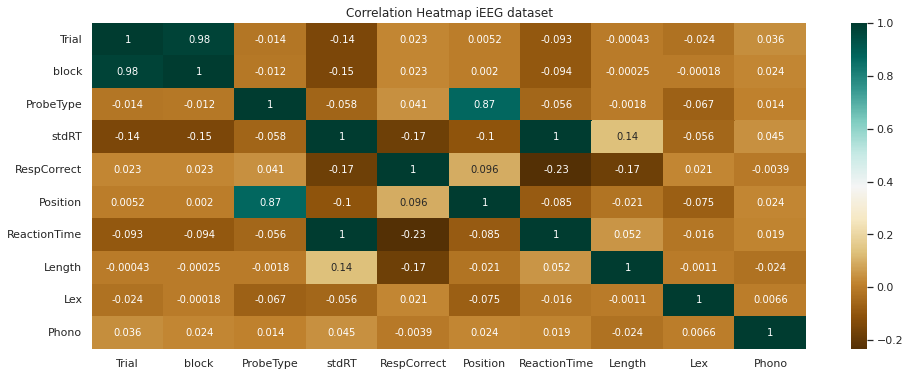

In [216]:
pl.figure(figsize=(16, 6))
map = sns.heatmap(ieeg_data.corr(), annot=True, cmap = 'BrBG')
map.set_title('Correlation Heatmap iEEG dataset');

In [238]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

In [271]:
ieeg_subset = ieeg_data[ieeg_data['Out'] != 'No Response']
match = ieeg_subset[ieeg_subset['ProbeType'] == 2]
mismatch = ieeg_subset[ieeg_subset['ProbeType'] == 1]

In [279]:
x, y = match[match['Lex'] == 1]['RespCorrect'].values, match[match['Lex'] == 0]['RespCorrect'].values
ttest(x, y)

Ttest_indResult(statistic=-1.9285683843978816, pvalue=0.05395525301632962)

In [280]:
for i in match.Length.unique():
  subset = match[match['Length'] == i]
  a = subset[subset['Lex'] == 0]['RespCorrect'].values
  b = subset[subset['Lex'] == 1]['RespCorrect'].values
  print(ttest(a,b), i)

Ttest_indResult(statistic=0.6429707746721036, pvalue=0.5206143110083132) 3
Ttest_indResult(statistic=0.49507108505129294, pvalue=0.6207958084308167) 7
Ttest_indResult(statistic=0.811197392751667, pvalue=0.41772686470597165) 9
Ttest_indResult(statistic=2.4260492883148665, pvalue=0.015793064525775218) 5


In [278]:
for i in match.Length.unique():
  subset = match[match['Length'] == i]
  a = subset[subset['Phono'] == 0]['RespCorrect'].values
  b = subset[subset['Phono'] == 1]['RespCorrect'].values
  print(ttest(a,b), i)


Ttest_indResult(statistic=-0.5028338304724563, pvalue=0.6153421491110809) 3
Ttest_indResult(statistic=-0.8396160908191973, pvalue=0.40161830019338407) 7
Ttest_indResult(statistic=-1.9555000521555255, pvalue=0.0512498186529689) 9
Ttest_indResult(statistic=-0.02796091720310665, pvalue=0.9777065841534331) 5


## Models

In [333]:
model_main = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + (1|Subject)',
    data = ieeg_data
)
model_main.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3754	 Groups: {'Subject': 24.0}

Log-likelihood: -1448.796 	 AIC: 2897.592

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.125  0.353

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.963   0.911    1.016  0.027  1108.252  36.078  0.000  ***
Phono          -0.002  -0.025    0.020  0.012  3739.064  -0.205  0.837     
Lex             0.018  -0.005    0.040  0.012  3726.460   1.541  0.124     
Length         -0.029  -0.034   -0.024  0.003  3726.446 -11.230  0.000  ***
ProbeType       0.033   0.010    0.056  0.012  3742.068   2.828  0.005   **

In [335]:
model_main1 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + Phono*Lex + Phono*Length + Phono*ProbeType + Lex*Length + Lex*ProbeType + Length*ProbeType + (1|Subject)',
    data = ieeg_data
)
model_main1.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+Phono*Lex+Phono*Length+Phono*ProbeType+Lex*Length+Lex*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3754	 Groups: {'Subject': 24.0}

Log-likelihood: -1455.145 	 AIC: 2910.290

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.124  0.352

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.867   0.741    0.993  0.064  3582.313  13.451  0.000   
Phono               -0.134  -0.231   -0.036  0.050  3725.184  -2.682  0.007   
Lex                  0.154   0.057    0.251  0.049  3733.970   3.117  0.002   
Length              -0.019  -0.037   -0.001  0.009  3723.112  -2.107  0.035   
ProbeType            0.124   0.051    0.197  0.037  3722.858   3.333  0.001   
Phono:Lex            0.035  -0.010    0.080  0.023  3730.054   1.510  0.131   
Phono:Length         0.010  -0.001    0.020  0.005  3731.215   1.863  0.063   
Phono:ProbeType      0.037  -0.008    0.083  0.023  3721.078   1.602  0.109   
Lex:Length          -0.000  -0.010    0.010  0.005  3720.371  -0.061  0.951   
Lex:ProbeType       -0.103  -0.148   -0.058  0.023  3738.494  -4.447  0.000   
Length:ProbeType    -0.010  -0.020   -0.000  0.005  3724.115  -1.961  0.050   

                  Sig  
(Intercept)       ***  
Phono              **  
Lex                **  
Length              *  
ProbeType         ***  
Phono:Lex              
Phono:Length        .  
Phono:ProbeType        
Lex:Length             
Lex:ProbeType     ***  
Length:ProbeType    *

In [ ]:
model_main2 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + Phono*Lex + Phono*Length + Phono*ProbeType + Lex*Length + Lex*ProbeType + Length*ProbeType + Phono*Lex*Length + Phono*Lex*ProbeType + Phono*Length*ProbeType + Length*Lex*ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main2.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+Phono*Lex+Phono*Length+Phono*ProbeType+Lex*Length+Lex*ProbeType+Length*ProbeType+Phono*Lex*Length+Phono*Lex*ProbeType+Phono*Length*ProbeType+Length*Lex*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1441.279 	 AIC: 2882.558

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.119  0.345

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                0.928   0.745    1.112  0.094  3856.936   9.927   
Phono                     -0.044  -0.265    0.178  0.113  3848.855  -0.388   
Lex                        0.072  -0.148    0.292  0.112  3842.474   0.640   
Length                    -0.026  -0.054    0.002  0.014  3844.513  -1.817   
ProbeType                  0.086  -0.029    0.202  0.059  3844.205   1.469   
Phono:Lex                  0.025  -0.156    0.207  0.093  3845.880   0.272   
Phono:Length              -0.011  -0.043    0.022  0.017  3847.328  -0.628   
Phono:ProbeType            0.002  -0.132    0.136  0.068  3844.525   0.029   
Lex:Length                 0.011  -0.021    0.043  0.016  3843.010   0.669   
Lex:ProbeType             -0.047  -0.181    0.088  0.069  3842.848  -0.679   
Length:ProbeType          -0.006  -0.024    0.012  0.009  3845.032  -0.675   
Phono:Lex:Length           0.003  -0.016    0.023  0.010  3844.486   0.334   
Phono:Lex:ProbeType       -0.006  -0.094    0.082  0.045  3853.109  -0.132   
Phono:Length:ProbeType     0.010  -0.009    0.030  0.010  3845.720   1.040   
Lex:Length:ProbeType      -0.009  -0.028    0.011  0.010  3844.700  -0.848   

                        P-val  Sig  
(Intercept)             0.000  ***  
Phono                   0.698       
Lex                     0.522       
Length                  0.069    .  
ProbeType               0.142       
Phono:Lex               0.785       
Phono:Length            0.530       
Phono:ProbeType         0.977       
Lex:Length              0.504       
Lex:ProbeType           0.497       
Length:ProbeType        0.499       
Phono:Lex:Length        0.739       
Phono:Lex:ProbeType     0.895       
Phono:Length:ProbeType  0.299       
Lex:Length:ProbeType    0.397

In [ ]:
model_main3 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + ProbeType + Phono*Lex + Phono*Length + Phono*ProbeType + Lex*Length + Lex*ProbeType + Length*ProbeType + Phono*Lex*Length + Phono*Length*ProbeType + Phono*Lex*ProbeType + Length*Lex*ProbeType + Phono*Lex*Length*ProbeType + (1|Subject)',
    data = ieeg_sh
)
model_main3.fit()

Formula: RespCorrect~Phono+Lex+Length+ProbeType+Phono*Lex+Phono*Length+Phono*ProbeType+Lex*Length+Lex*ProbeType+Length*ProbeType+Phono*Lex*Length+Phono*Length*ProbeType+Phono*Lex*ProbeType+Length*Lex*ProbeType+Phono*Lex*Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1444.155 	 AIC: 2888.310

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.119  0.345

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  \
(Intercept)                    0.905   0.699    1.112  0.106  3862.215   
Phono                         -0.001  -0.286    0.283  0.145  3854.139   
Lex                            0.116  -0.171    0.403  0.147  3850.276   
Length                        -0.022  -0.054    0.010  0.016  3845.105   
ProbeType                      0.102  -0.031    0.234  0.068  3845.693   
Phono:Lex                     -0.058  -0.452    0.336  0.201  3861.161   
Phono:Length                  -0.018  -0.062    0.027  0.023  3852.295   
Phono:ProbeType               -0.026  -0.205    0.152  0.091  3851.973   
Lex:Length                     0.004  -0.041    0.048  0.023  3850.858   
Lex:ProbeType                 -0.076  -0.260    0.107  0.094  3852.279   
Length:ProbeType              -0.009  -0.029    0.012  0.011  3843.552   
Phono:Lex:Length               0.017  -0.044    0.078  0.031  3857.662   
Phono:Length:ProbeType         0.015  -0.013    0.043  0.014  3849.728   
Phono:Lex:ProbeType            0.051  -0.203    0.305  0.129  3863.527   
Lex:Length:ProbeType          -0.004  -0.032    0.025  0.015  3852.824   
Phono:Lex:Length:ProbeType    -0.009  -0.049    0.030  0.020  3859.890   

                            T-stat  P-val  Sig  
(Intercept)                  8.577  0.000  ***  
Phono                       -0.008  0.994       
Lex                          0.791  0.429       
Length                      -1.348  0.178       
ProbeType                    1.509  0.131       
Phono:Lex                   -0.289  0.772       
Phono:Length                -0.779  0.436       
Phono:ProbeType             -0.288  0.773       
Lex:Length                   0.165  0.869       
Lex:ProbeType               -0.815  0.415       
Length:ProbeType            -0.820  0.412       
Phono:Lex:Length             0.550  0.583       
Phono:Length:ProbeType       1.066  0.286       
Phono:Lex:ProbeType          0.393  0.695       
Lex:Length:ProbeType        -0.245  0.807       
Phono:Lex:Length:ProbeType  -0.467  0.640

**Without match/mismatch**

In [ ]:
model_noprobe = Lmer(
    'RespCorrect ~ Phono + Lex + Length + (1|Subject)',
    data = ieeg_sh
)
model_noprobe.fit()

Formula: RespCorrect~Phono+Lex+Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1424.260 	 AIC: 2848.520

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.031   0.993    1.070  0.019   458.699  53.048  0.000  ***
Phono           0.008  -0.014    0.030  0.011  3869.833   0.749  0.454     
Lex             0.010  -0.012    0.032  0.011  3852.468   0.877  0.380     
Length         -0.032  -0.037   -0.027  0.002  3853.421 -12.733  0.000  ***

In [ ]:
model_noprobe1 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + Phono*Lex + Lex*Length + Phono*Length + (1|Subject)',
    data = ieeg_sh
)
model_noprobe1.fit()

Formula: RespCorrect~Phono+Lex+Length+Phono*Lex+Lex*Length+Phono*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1434.460 	 AIC: 2868.919

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)      1.062   1.002    1.121  0.030  1777.286  34.999  0.000  ***
Phono           -0.042  -0.108    0.025  0.034  3862.114  -1.226  0.220     
Lex             -0.011  -0.079    0.056  0.034  3850.316  -0.334  0.739     
Length          -0.036  -0.044   -0.027  0.004  3854.924  -7.956  0.000  ***
Phono:Lex        0.026  -0.018    0.070  0.022  3857.134   1.159  0.246     
Lex:Length       0.001  -0.009    0.011  0.005  3849.525   0.243  0.808     
Phono:Length     0.006  -0.004    0.016  0.005  3861.781   1.234  0.217

In [ ]:
model_noprobe2 = Lmer(
    'RespCorrect ~ Phono + Lex + Length + Phono*Lex + Lex*Length + Phono*Length + Phono*Lex*Length + (1|Subject)',
    data = ieeg_sh
)
model_noprobe2.fit()

Formula: RespCorrect~Phono+Lex+Length+Phono*Lex+Lex*Length+Phono*Length+Phono*Lex*Length+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3881	 Groups: {'Subject': 26.0}

Log-likelihood: -1438.100 	 AIC: 2876.201

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.037
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.057   0.989    1.125  0.035  2328.100  30.480  0.000   
Phono               -0.032  -0.122    0.057  0.046  3859.036  -0.714  0.475   
Lex                 -0.002  -0.094    0.090  0.047  3850.125  -0.037  0.971   
Length              -0.035  -0.045   -0.024  0.005  3853.562  -6.602  0.000   
Phono:Lex            0.008  -0.118    0.133  0.064  3852.169   0.121  0.904   
Lex:Length          -0.000  -0.015    0.014  0.007  3849.735  -0.054  0.957   
Phono:Length         0.005  -0.009    0.019  0.007  3857.332   0.654  0.513   
Phono:Lex:Length     0.003  -0.017    0.023  0.010  3850.998   0.303  0.762   

                  Sig  
(Intercept)       ***  
Phono                  
Lex                    
Length            ***  
Phono:Lex              
Lex:Length             
Phono:Length           
Phono:Lex:Length

**Words vs. Non-words**

In [ ]:
words_ieeg = ieeg_sh[ieeg_sh['Lex'] == 1]
nonwords_ieeg = ieeg_sh[ieeg_sh['Lex'] == 0]

In [ ]:
model_words_ieeg = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + (1|Subject)',
    data = words_ieeg
)
model_words_ieeg.fit()

Formula: RespCorrect~Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1943	 Groups: {'Subject': 26.0}

Log-likelihood: -684.055 	 AIC: 1368.111

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.057
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     1.059   0.991    1.127  0.035   735.395  30.644  0.000  ***
Phono           0.021  -0.009    0.052  0.015  1917.777   1.375  0.169     
Length         -0.031  -0.038   -0.025  0.003  1914.643  -9.112  0.000  ***
ProbeType      -0.019  -0.050    0.012  0.016  1936.348  -1.209  0.227

In [ ]:
model_nonwords_ieeg = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + (1|Subject)',
    data = nonwords_ieeg
)
model_nonwords_ieeg.fit()

Formula: RespCorrect~Phono+Length+ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1938	 Groups: {'Subject': 26.0}

Log-likelihood: -734.341 	 AIC: 1468.682

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.123  0.350

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.914   0.846    0.983  0.035  1385.438  26.262  0.000  ***
Phono          -0.010  -0.042    0.021  0.016  1933.975  -0.642  0.521     
Length         -0.032  -0.039   -0.025  0.004  1911.127  -8.950  0.000  ***
ProbeType       0.085   0.053    0.116  0.016  1920.102   5.312  0.000  ***

In [ ]:
model_words_ieeg1 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)',
    data = words_ieeg
)
model_words_ieeg1.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1943	 Groups: {'Subject': 26.0}

Log-likelihood: -691.498 	 AIC: 1382.996

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          1.048   0.893    1.203  0.079  1893.692  13.256  0.000   
Phono               -0.104  -0.228    0.020  0.063  1914.297  -1.639  0.101   
Length              -0.023  -0.045   -0.000  0.011  1915.922  -1.988  0.047   
ProbeType            0.009  -0.084    0.102  0.048  1914.629   0.189  0.850   
Phono:Length         0.009  -0.005    0.022  0.007  1918.038   1.246  0.213   
Phono:ProbeType      0.052  -0.009    0.114  0.031  1920.044   1.669  0.095   
Length:ProbeType    -0.010  -0.023    0.004  0.007  1916.559  -1.368  0.172   

                  Sig  
(Intercept)       ***  
Phono                  
Length              *  
ProbeType              
Phono:Length           
Phono:ProbeType     .  
Length:ProbeType

In [ ]:
model_nonwords_ieeg1 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + (1|Subject)',
    data = nonwords_ieeg
)
model_nonwords_ieeg1.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1938	 Groups: {'Subject': 26.0}

Log-likelihood: -742.846 	 AIC: 1485.692

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.123  0.350

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  \
(Intercept)          0.978   0.820    1.136  0.080  1929.447  12.151  0.000   
Phono               -0.131  -0.263    0.000  0.067  1921.011  -1.953  0.051   
Length              -0.034  -0.057   -0.011  0.012  1909.123  -2.902  0.004   
ProbeType            0.052  -0.044    0.148  0.049  1908.820   1.056  0.291   
Phono:Length         0.005  -0.010    0.019  0.007  1921.560   0.633  0.527   
Phono:ProbeType      0.062  -0.001    0.125  0.032  1914.186   1.936  0.053   
Length:ProbeType    -0.000  -0.014    0.014  0.007  1910.547  -0.005  0.996   

                  Sig  
(Intercept)       ***  
Phono               .  
Length             **  
ProbeType              
Phono:Length           
Phono:ProbeType     .  
Length:ProbeType

In [ ]:
model_words_ieeg2 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + ProbeType*Length*Phono + (1|Subject)',
    data = words_ieeg
)
model_words_ieeg2.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+ProbeType*Length*Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1943	 Groups: {'Subject': 26.0}

Log-likelihood: -694.611 	 AIC: 1389.223

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.003  0.056
Residual               0.115  0.339

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                1.006   0.808    1.203  0.101  1926.777   9.979   
Phono                     -0.021  -0.289    0.246  0.137  1925.801  -0.155   
Length                    -0.016  -0.046    0.015  0.015  1920.836  -1.014   
ProbeType                  0.038  -0.087    0.163  0.064  1920.339   0.594   
Phono:Length              -0.005  -0.047    0.037  0.021  1921.109  -0.237   
Phono:ProbeType           -0.006  -0.183    0.171  0.090  1929.686  -0.062   
Length:ProbeType          -0.014  -0.034    0.005  0.010  1923.949  -1.447   
Phono:Length:ProbeType     0.010  -0.018    0.037  0.014  1925.598   0.682   

                        P-val  Sig  
(Intercept)             0.000  ***  
Phono                   0.877       
Length                  0.311       
ProbeType               0.553       
Phono:Length            0.812       
Phono:ProbeType         0.951       
Length:ProbeType        0.148       
Phono:Length:ProbeType  0.495

In [ ]:
model_nonwords_ieeg2 = Lmer(
    'RespCorrect ~ Phono + Length + ProbeType + Phono*Length + Phono*ProbeType + Length*ProbeType + ProbeType*Length*Phono + (1|Subject)',
    data = nonwords_ieeg
)
model_nonwords_ieeg2.fit()

Formula: RespCorrect~Phono+Length+ProbeType+Phono*Length+Phono*ProbeType+Length*ProbeType+ProbeType*Length*Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1938	 Groups: {'Subject': 26.0}

Log-likelihood: -745.447 	 AIC: 1490.893

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.029
Residual               0.122  0.350

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  \
(Intercept)                0.893   0.684    1.103  0.107  1929.931   8.359   
Phono                      0.026  -0.262    0.314  0.147  1926.240   0.177   
Length                    -0.020  -0.053    0.012  0.017  1913.759  -1.225   
ProbeType                  0.109  -0.025    0.243  0.068  1914.862   1.595   
Phono:Length              -0.022  -0.066    0.023  0.023  1924.149  -0.942   
Phono:ProbeType           -0.042  -0.223    0.139  0.092  1923.726  -0.456   
Length:ProbeType          -0.010  -0.030    0.011  0.011  1911.326  -0.893   
Phono:Length:ProbeType     0.017  -0.011    0.045  0.014  1920.794   1.202   

                        P-val  Sig  
(Intercept)             0.000  ***  
Phono                   0.860       
Length                  0.221       
ProbeType               0.111       
Phono:Length            0.346       
Phono:ProbeType         0.648       
Length:ProbeType        0.372       
Phono:Length:ProbeType  0.230

**Models after comparison**

In [302]:
eeg_data.head()

Trial Subject  Block  ProbeType     stdRT  ResponseCorrect  Position  \
0      0      E2      1          1       NaN                0         0   
1      1      E2      1          2  0.401952                1         3   
2      2      E2      1          2 -0.401598                1         3   
3      3      E2      1          2  1.239013                1         1   
4      4      E2      1          1  0.134058                1         0   

      Response  Length  Lex  Phono  
0  No Response       5    1      1  
1          Yes       5    0      1  
2          Yes       9    1      1  
3          Yes       5    1      0  
4           No       7    0      0

In [303]:
ieeg_data.head()

Trial Subject  block Out  ProbeType     stdRT  RespCorrect  Position Resp  \
0      0     D23      1   1          2 -0.896086            1         1  Yes   
1      1     D23      1   1          2  0.574265            1         1  Yes   
2      2     D23      1   1          2 -0.322269            1         2  Yes   
3      3     D23      1   1          1  1.054321            1         0   No   
4      4     D23      1   1          1  1.611803            1         0   No   

   ReactionTime  Length  Lex  Phono  
0      0.857518       3    1      1  
1      1.339604       7    1      0  
2      1.045657       7    0      0  
3      1.497001       9    1      1  
4      1.679783       5    1      0

In [317]:
eeg_data.Trial.dtype

dtype('int64')

In [318]:
ieeg_data.Trial.dtype

dtype('int64')

In [300]:
%reload_ext rpy2.ipython


In [324]:
words = eeg_data[eeg_data['Lex'] == 0]

In [328]:
words = words.loc[:, words.columns != 'Lex']
words.head()

Trial Subject  Block  ProbeType     stdRT  ResponseCorrect  Position  \
1       1      E2      1          2  0.401952                1         3   
4       4      E2      1          1  0.134058                1         0   
5       5      E2      1          2  1.177841                1         1   
9       9      E2      1          2  0.656322                0         2   
10     10      E2      1          1 -0.404359                1         0   

   Response  Length  Phono  
1       Yes       5      1  
4        No       7      0  
5       Yes       9      0  
9        No       7      0  
10       No       5      0

In [331]:
%%R
m<-lmer('ResponseCorrect ~ Lex + (1|Subject)', data=words)
print(summary(m))


Error in exists(v, envir = env, inherits = FALSE) : 
  use of NULL environment is defunct


RInterpreterError: ignored

In [330]:
%%R
data<-words
m <- lmer('ResponseCorrect ~ Lex + Phono + (1|Subject)', data=data)
m1 <- lmer('ResponseCorrect ~ Lex + (1|Subject)', data=data)
anova(m, m1)


Error in withVisible({ : object 'words' not found


RInterpreterError: ignored

### Extra

## The effect of the experiment part on Accuracy

In [ ]:
# wanna check is there any difference depending on the part of experiment
# beginning of the experiment vs. the end 

**EEG dataset**

In [ ]:
trial_category = []
for i in eeg_data.Subject.unique():
  subset = eeg_data[eeg_data['Subject'] == i]
  for i in range(0, subset.shape[0]):
    if i < 63:
      trial_category.append('beginning')
    elif 63 <= i <= 126:
      trial_category.append('middle')
    elif 126 < i <= 191:
      trial_category.append('end')

In [ ]:
eeg_data['TrialPos'] = trial_category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


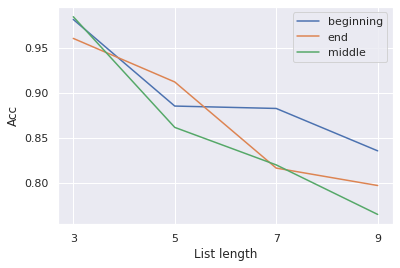

In [ ]:
pl.figure()
subset = eeg_data.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

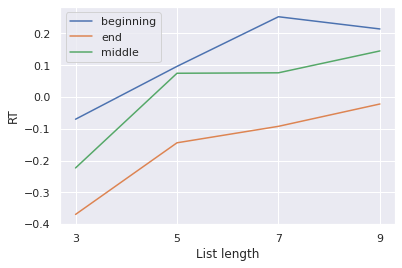

In [ ]:
pl.figure()
subset = eeg_data.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('RT')
pl.legend(subset.TrialPos.unique());

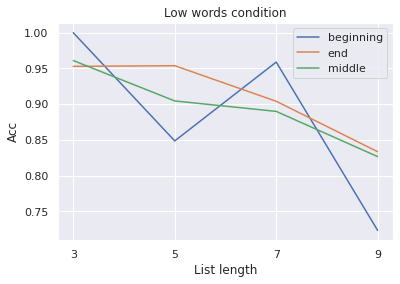

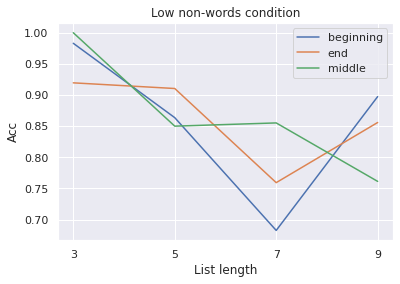

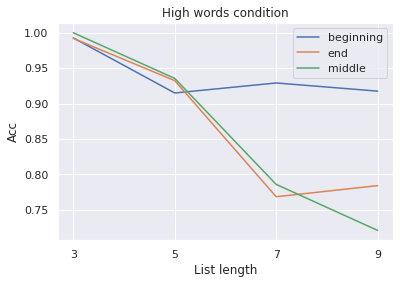

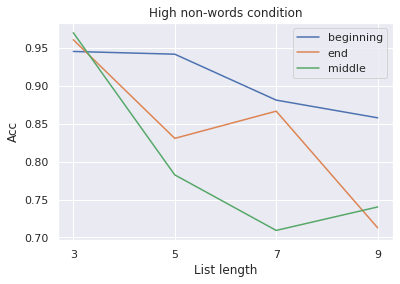

In [ ]:
# Accuracy
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

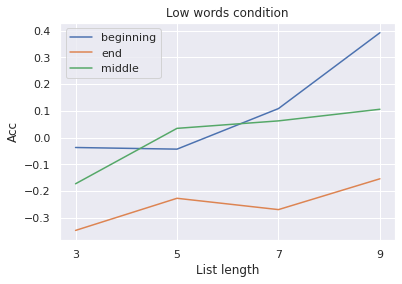

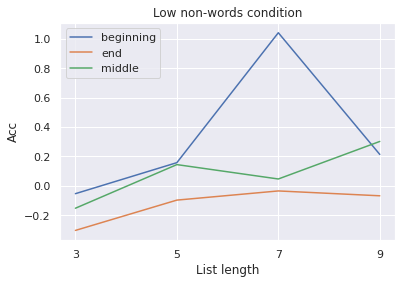

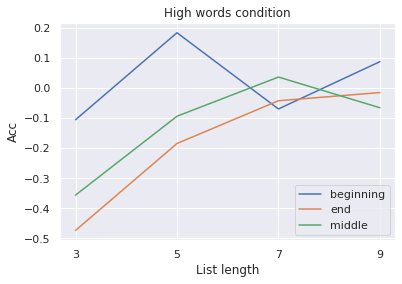

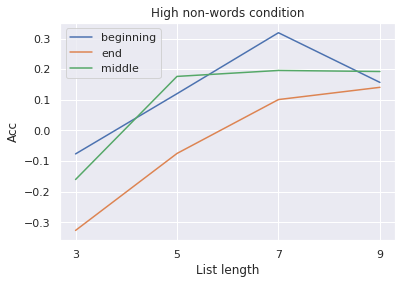

In [ ]:
# Reaction Time 
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 1) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = eeg_data[(eeg_data['Lex'] == 0) & (eeg_data['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

In [ ]:
new = []
check = eeg_data.TrialPos.values
for i in range(0, len(check)):
  if check[i] == 'beginning':
    new.append(0)
  elif check[i] == 'middle':
    new.append(1)
  elif check[i] == 'end':
    new.append(2)
  else:
    print('Check')

In [ ]:
eeg_data['TrialP'] = new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_trialpos = Lmer(
    'ResponseCorrect ~ Lex + Length + TrialP + ProbeType + Phono + (1|Subject)',
    data = eeg_data
)
model_trialpos.fit()

Formula: ResponseCorrect~Lex+Length+TrialP+ProbeType+Phono+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 5334	 Groups: {'Subject': 29.0}

Log-likelihood: -1549.434 	 AIC: 3098.867

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.103  0.321

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.973   0.932    1.014  0.021   984.435  46.304  0.000  ***
Lex             0.031   0.014    0.048  0.009  5300.607   3.505  0.000  ***
Length         -0.028  -0.032   -0.024  0.002  5300.455 -14.418  0.000  ***
TrialP         -0.013  -0.024   -0.003  0.005  5310.982  -2.467  0.014    *
ProbeType       0.046   0.029    0.063  0.009  5306.918   5.198  0.000  ***
Phono          -0.000  -0.017    0.017  0.009  5301.145  -0.003  0.998

**iEEG dataset**

In [ ]:
ieeg_sh.head()

Trial Subject block  ProbeType     stdRT  RespCorrect  Position  Length  \
0      0     D23     1          2 -0.896484            1         1       3   
1      1     D23     1          2  0.564665            1         1       7   
2      2     D23     1          2 -0.326257            1         2       7   
3      3     D23     1          1  1.041717            1         0       9   
4      4     D23     1          1  1.595710            1         0       5   

   Lex  Phono  
0    1      1  
1    1      0  
2    0      0  
3    1      1  
4    1      0

In [ ]:
trial_category = []
for i in ieeg_sh.Subject.unique():
  subset = ieeg_sh[ieeg_sh['Subject'] == i]
  for i in range(0, subset.shape[0]):
    if i < 63:
      trial_category.append('beginning')
    elif 63 <= i <= 126:
      trial_category.append('middle')
    elif 126 < i <= 191:
      trial_category.append('end')

In [ ]:
ieeg_sh['TrialPos'] = trial_category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


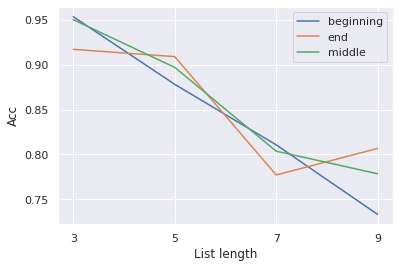

In [ ]:
pl.figure()
subset = ieeg_sh.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

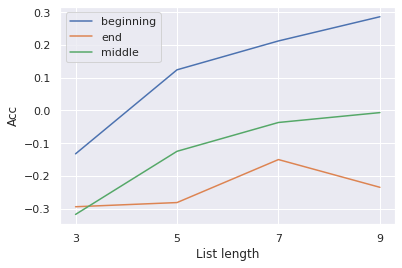

In [ ]:
pl.figure()
subset = ieeg_sh.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique());

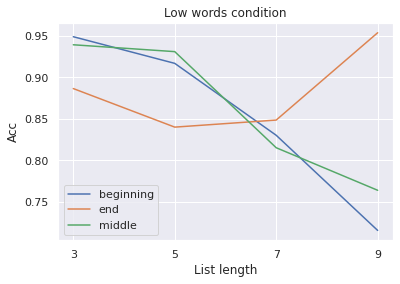

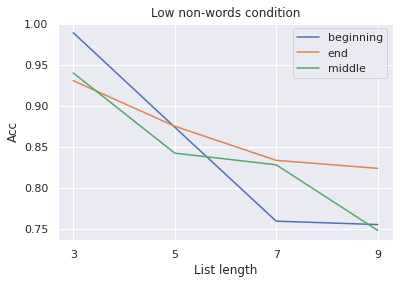

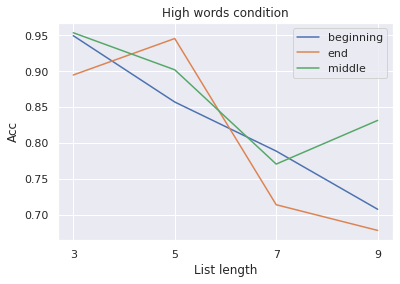

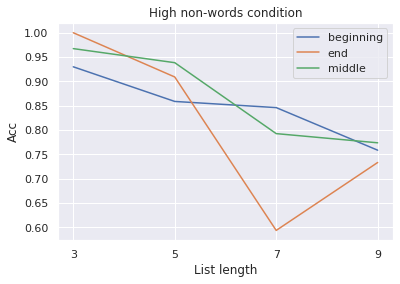

In [ ]:
# Accuracy
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

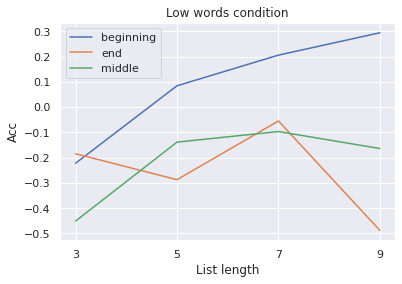

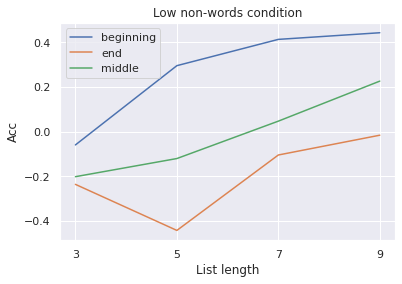

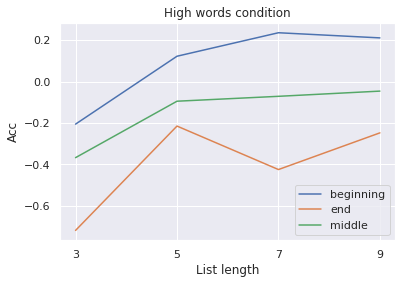

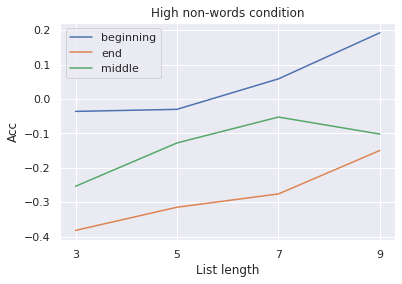

In [ ]:
# Reaction Time 
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low words condition');

pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 1)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('Low non-words condition');

  
pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 1) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High words condition')


pl.figure()
subset = ieeg_sh[(ieeg_sh['Lex'] == 0) & (ieeg_sh['Phono'] == 0)]
subset = subset.groupby(['TrialPos', 'Length'])[['stdRT']].mean().reset_index()
for i in subset.TrialPos.unique():
  x = subset[subset['TrialPos'] == i]
  pl.plot(x.Length, x.stdRT)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.TrialPos.unique())
pl.title('High non-words condition');

In [ ]:
ieeg_sh.head()

Trial Subject block  ProbeType     stdRT  RespCorrect  Position  Length  \
0      0     D23     1          2 -0.896484            1         1       3   
1      1     D23     1          2  0.564665            1         1       7   
2      2     D23     1          2 -0.326257            1         2       7   
3      3     D23     1          1  1.041717            1         0       9   
4      4     D23     1          1  1.595710            1         0       5   

   Lex  Phono   TrialPos  TrialP  
0    1      1  beginning       0  
1    1      0  beginning       0  
2    0      0  beginning       0  
3    1      1  beginning       0  
4    1      0  beginning       0

In [ ]:
new = []
check = ieeg_sh.TrialPos.values
for i in range(0, len(check)):
  if check[i] == 'beginning':
    new.append(0)
  elif check[i] == 'middle':
    new.append(1)
  elif check[i] == 'end':
    new.append(2)
  else:
    print('Check')

In [ ]:
ieeg_sh['TrialP'] = new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
model_trialpos_i = Lmer(
    'RespCorrect ~ Lex + Length + Phono + ProbeType + TrialP + (1|Subject)',
    data = ieeg_sh
)
model_trialpos_i.fit()

Formula: RespCorrect~Lex+Length+Phono+ProbeType+TrialP+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 3725	 Groups: {'Subject': 25.0}

Log-likelihood: -1372.663 	 AIC: 2745.326

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.038
Residual               0.120  0.347

No random effect correlations specified

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE        DF  T-stat  P-val  Sig
(Intercept)     0.980   0.927    1.033  0.027  1159.776  36.307  0.000  ***
Lex             0.011  -0.011    0.033  0.011  3695.580   0.959  0.338     
Length         -0.032  -0.037   -0.027  0.003  3696.417 -12.518  0.000  ***
Phono           0.008  -0.014    0.030  0.011  3712.172   0.700  0.484     
ProbeType       0.033   0.010    0.055  0.011  3707.061   2.855  0.004   **
TrialP          0.005  -0.011    0.020  0.008  3719.000   0.586  0.558

## Accuracy plots EEG with 'No response trials' as incorrect

1.   100 'No response' trials
2.   No subjects less than 75% accurate
3.   The max of no response trials - 10% of all trials



In [ ]:
eeg[eeg['Response'] == 'No Response'].groupby(['Subject'])[['Trial']].count()

In [70]:
eeg[eeg['Response'] == 'No Response'].groupby(['ProbeCategory'])[['Trial']].count()

Trial
ProbeCategory        
high non-words     28
high words         20
low non-words      32
low words          20

BOTH MATCH AND MISMATCH

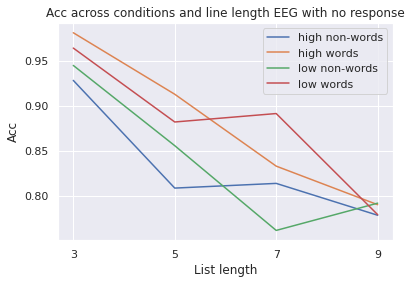

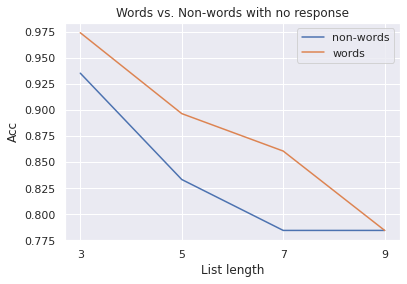

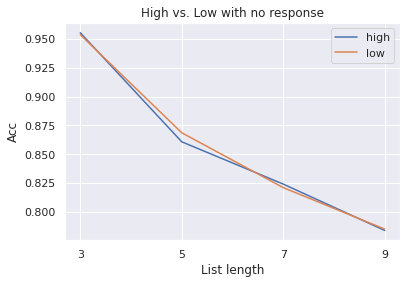

In [78]:
pl.figure()
subset = eeg.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG with no response');

pl.figure()
subset = eeg.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words with no response');

pl.figure()
subset = eeg.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low with no response');

ONLY MATCH

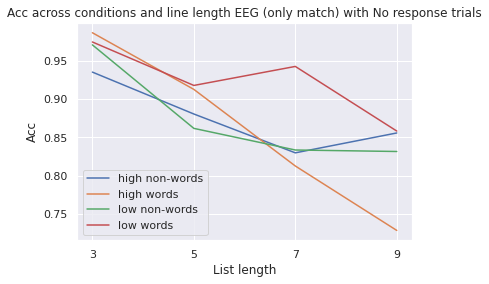

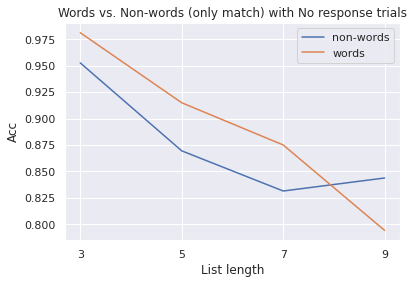

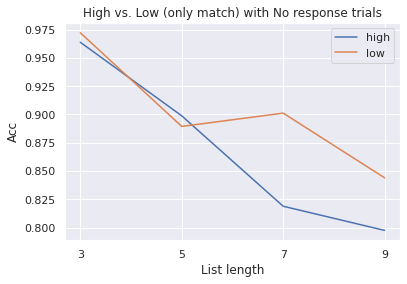

In [76]:
only_match = eeg[eeg['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.ResponseCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.ResponseCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match) with No response trials');

ONLY MISMATCH

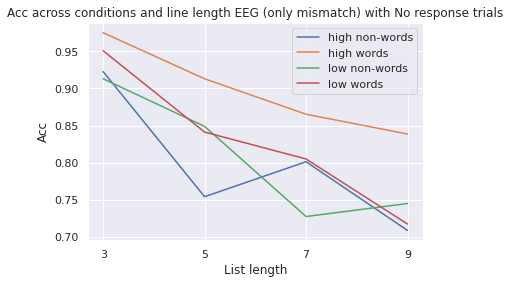

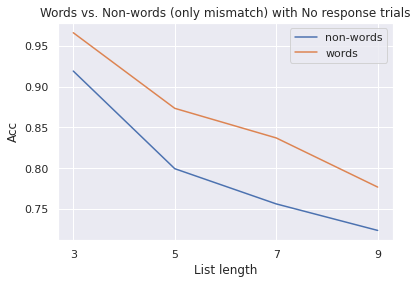

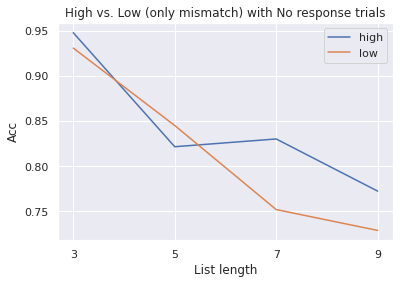

In [75]:
only_mismatch = eeg[eeg['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.ResponseCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length EEG (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch) with No response trials');

MATCH AND MISMATCH ON THE SAME PLOT

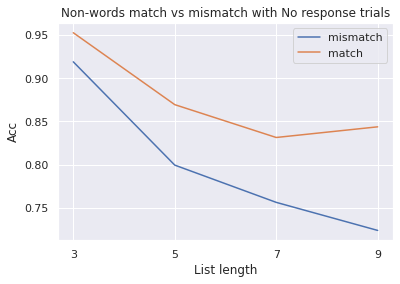

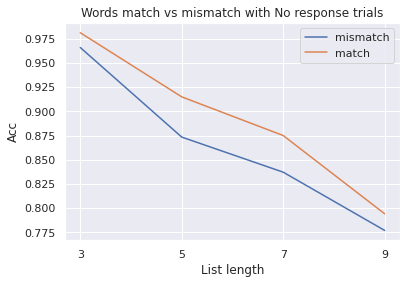

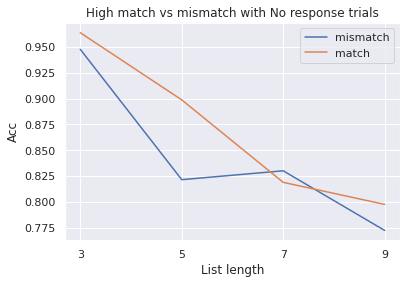

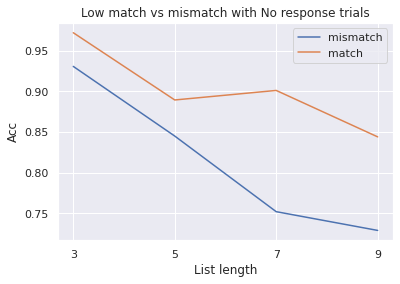

In [74]:
pl.figure()
nonwords = eeg[eeg['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch with No response trials');

pl.figure()
words = eeg[eeg['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch with No response trials');

pl.figure()
high = eeg[eeg['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch with No response trials');

pl.figure()
low = eeg[eeg['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['ResponseCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.ResponseCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch with No response trials');

## Accuracy plots iEEG dataset with 'No response' trials

BOTH MATCH AND MISMATCH

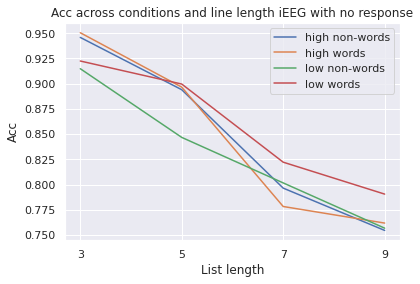

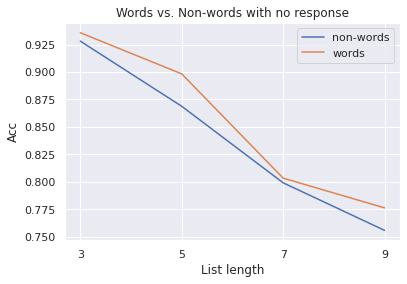

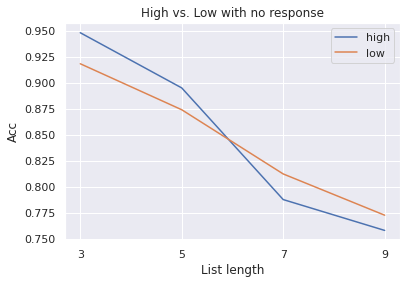

In [231]:
pl.figure()
subset = ieeg_no_outliers.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length iEEG with no response');

pl.figure()
subset = ieeg_no_outliers.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words with no response');

pl.figure()
subset = ieeg_no_outliers.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low with no response');

ONLY MATCH

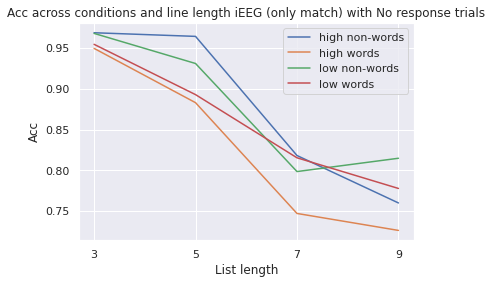

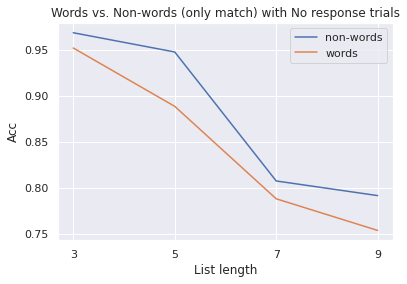

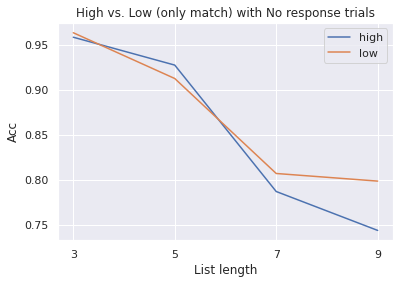

In [232]:
only_match = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 2]

pl.figure()
subset = only_match.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length iEEG (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    pl.plot(x.Length, x.RespCorrect, label = 'non-words')
  elif i == 1:
      pl.plot(x.Length, x.RespCorrect, label = 'words')
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only match) with No response trials');

pl.figure()
subset = only_match.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only match) with No response trials');

ONLY MISMATCH

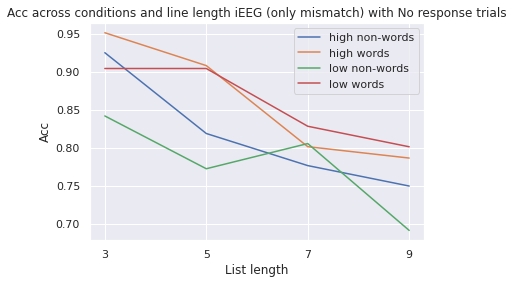

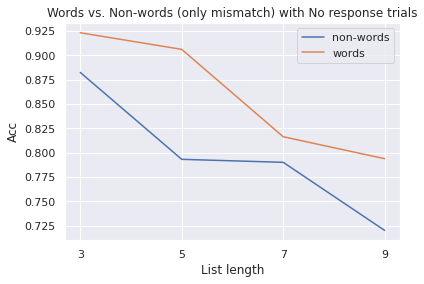

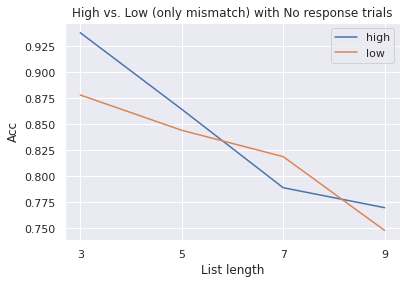

In [233]:
only_mismatch = ieeg_no_outliers[ieeg_no_outliers['ProbeType'] == 1]

pl.figure()
subset = only_mismatch.groupby(['ProbeCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeCategory.unique():
  x = subset[subset['ProbeCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.ProbeCategory.unique())
pl.title('Acc across conditions and line length iEEG (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Lex', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Lex.unique():
  x = subset[subset['Lex'] == i]
  if i == 0:
    name = 'non-words'
  elif i == 1:
    name = 'words'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words vs. Non-words (only mismatch) with No response trials');

pl.figure()
subset = only_mismatch.groupby(['Phono', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.Phono.unique():
  x = subset[subset['Phono'] == i]
  if i == 0:
    name = 'high'
  elif i == 1:
    name = 'low'
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High vs. Low (only mismatch) with No response trials');

MATCH AND MISMATCH ON THE SAME PLOT

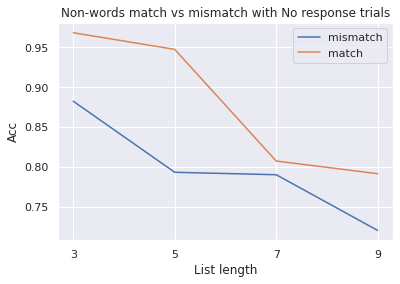

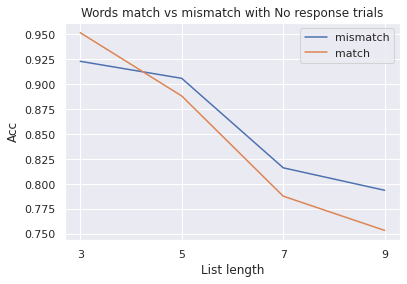

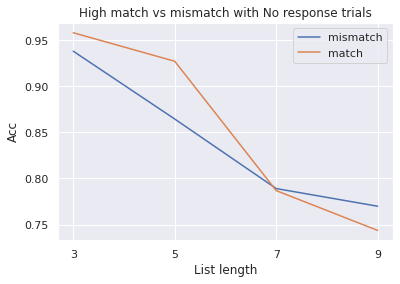

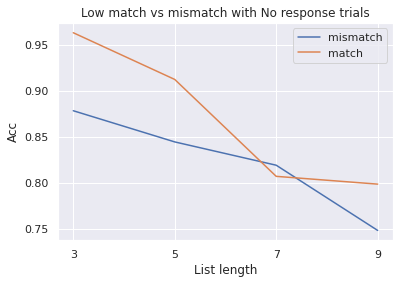

In [234]:
pl.figure()
nonwords = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 0]
subset = nonwords.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Non-words match vs mismatch with No response trials');

pl.figure()
words = ieeg_no_outliers[ieeg_no_outliers['Lex'] == 1]
subset = words.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Words match vs mismatch with No response trials');

pl.figure()
high = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 0]
subset = high.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('High match vs mismatch with No response trials');

pl.figure()
low = ieeg_no_outliers[ieeg_no_outliers['Phono'] == 1]
subset = low.groupby(['ProbeType', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.ProbeType.unique():
  if i == 1:
    name = 'mismatch'
  elif i == 2:
    name = 'match'
  x = subset[subset['ProbeType'] == i]
  pl.plot(x.Length, x.RespCorrect, label = name)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend()
pl.title('Low match vs mismatch with No response trials');